### Calculating Orientation

[LinearScan] subhalo 563732 found in fof_subhalo_tab_099.336.hdf5 (local 1394)
[CAT] h=0.677400  Box=35000.0 ckpc/h  center=[23253.01757812 17960.3046875   8687.81640625]  rhalf(star)=3.581 ckpc/h
[INFO] Aperture cut: rhalf*10.0 = 35.81 ckpc/h | kept 635807 stars
[INFO] Subhalo 563732 | N*=635807
  SubhaloSpin TOT    J = [-433.94714355  595.24847412 -465.67276001]   | inc=57.70°, PA=36.09°
  Stellar-only  J*   = [ -351.37537555  1249.47884486 -1225.54768997]    | inc=46.64°, PA=15.71°
  Angles between directions (deg):
    angle(J_tot,  J_star)  =  19.45
    angle(J_tot,  v3_pca)  = 160.46   (v3 ~ morphological normal)
    angle(J_star, v3_pca)  = 179.90
  2D PCA major-axis angle in XY (deg, from +x): 17.17 (expect ~ PA if inclined)
[RMS z] edge-on (SubhaloSpin) = 2.883 kpc
[RMS z] edge-on (stellar)     = 2.021 kpc
[RMS z] edge-on (PCA)         = 2.021 kpc


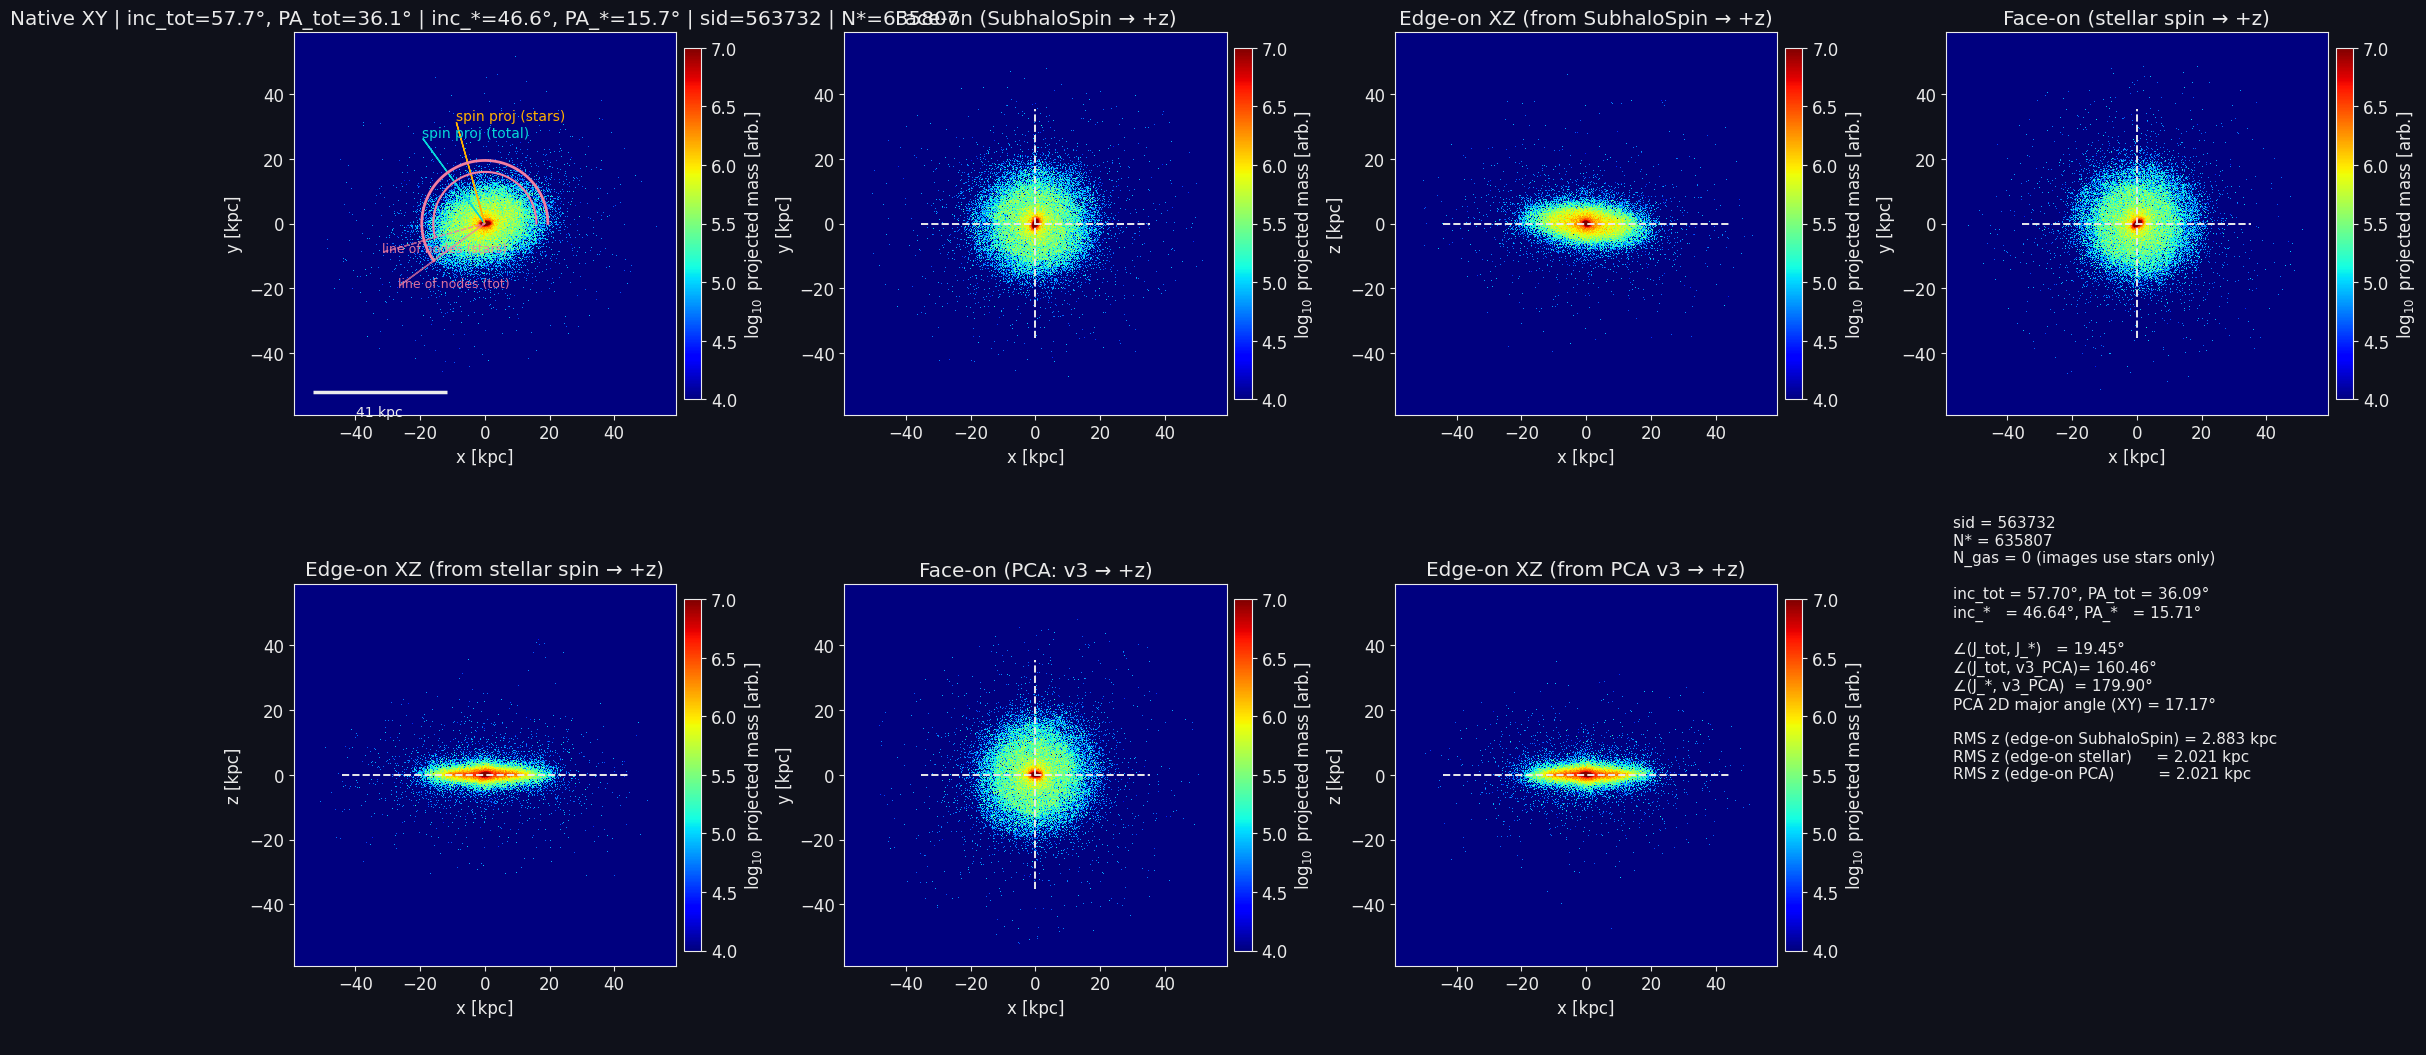

[SAVED] /Users/tsingh65/github_repos/COS-GASS/tests/56372_sightlines/tng_orientation_checks_debug/debug_sid563732_part-stars_snap99.png
[SAVED] /Users/tsingh65/github_repos/COS-GASS/tests/56372_sightlines/tng_orientation_checks_debug/orientation_sid563732_snap99.json
[SAVED] /Users/tsingh65/github_repos/COS-GASS/tests/56372_sightlines/tng_orientation_checks_debug/orientation_sid563732_snap99.csv


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Local (mac) orientation debug from a single TNG cutout + local group catalog.

- Orientation estimators (stars only):
    * SubhaloSpin (catalog, total)  J_tot
    * Stellar spin from cutout      J_star
    * PCA v3 (minor axis)           v3_hat
- Imaging uses STARS ONLY (to match your TNG reference figure). You can flip a flag
  to include gas visually if you want (doesn't affect the orientation calcs).

Saves:
  tests/56372_sightlines/tng_orientation_checks_debug/debug_sid<SID>_part-stars_snap<SNAP>.png
  tests/56372_sightlines/tng_orientation_checks_debug/orientation_sid<SID>_snap<SNAP>.json
  tests/56372_sightlines/tng_orientation_checks_debug/orientation_sid<SID>_snap<SNAP>.csv
"""

import os, json, glob, h5py
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import illustris_python as il  # pip install illustris_python

# ────────────── USER PATHS (EDIT if your paths differ) ──────────────
CUTOUT_H5     = r"/Users/tsingh65/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/cutout_ALLFIELDS_sphere_2p1Rvir_sub563732.hdf5"
GROUPCAT_BASE = r"/Users/tsingh65/ASU Dropbox/Tanmay Singh/COS_GASS"   # contains groups_099/
OUT_DIR       = r"/Users/tsingh65/github_repos/COS-GASS/tests/56372_sightlines/tng_orientation_checks_debug"

SNAP          = 99
SID           = 563732

# Imaging from stars only (to match your TNG plots). Set True to add gas visually.
INCLUDE_GAS_IN_IMAGES = False

# ────────────── Figure / style (match your TNG plot) ──────────────
part                = "stars"
extent_kpc_h        = 80.0
nbin                = 1200
REMOVE_BULK_VEL     = False
use_rhalf_aperture  = True
rhalf_multiplier    = 10.0

dpi_out        = 120
cmap_name      = "jet"
bg_color       = "#0f111a"
fg_color       = "#eaeaea"
spin_tot_color = "#06d7d9"
spin_star_color= "#ffb000"
nodes_color    = "#f37ea1"
axes_guide     = "#eaeaea"
scalebar_color = "#eaeaea"
VMIN = 4.0
VMAX = 7.0

mpl.rcParams.update({
    "figure.facecolor": bg_color, "axes.facecolor": bg_color, "savefig.facecolor": bg_color,
    "axes.edgecolor": fg_color, "axes.labelcolor": fg_color, "xtick.color": fg_color,
    "ytick.color": fg_color, "text.color": fg_color, "font.family": "DejaVu Sans", "font.size": 12,
})

# ────────────── Helpers ──────────────
def unit(v):
    v = np.asarray(v, float)
    n = np.linalg.norm(v)
    return v / n if n > 0 else v

def minimal_image_delta(dpos, box):
    return (dpos + 0.5*box) % box - 0.5*box

def recenter_positions(x, center, box):
    return minimal_image_delta(x - center[None, :], box)

def rodrigues_u_to_v(u, v):
    """Active rotation mapping u -> v; returns R so that R @ u == v."""
    u = unit(u); v = unit(v)
    c = float(np.clip(np.dot(u, v), -1.0, 1.0))
    if c > 1 - 1e-12:
        return np.eye(3)
    if c < -1 + 1e-12:
        a = unit(np.cross(u, [1,0,0]) if abs(u[0]) < 0.9 else np.cross(u, [0,1,0]))
        K = np.array([[0,-a[2],a[1]],[a[2],0,-a[0]],[-a[1],a[0],0]])
        return np.eye(3) + 2*(K @ K)    # π-rotation
    a = np.cross(u, v); s = float(np.linalg.norm(a))
    a = a / s
    K = np.array([[0,-a[2],a[1]],[a[2],0,-a[0]],[-a[1],a[0],0]])
    return np.eye(3) + K*s + (K @ K)*(1 - c)

def inc_PA_from_vector(J):
    """
    inc (deg): inclination wrt +z (0 face-on, 90 edge-on), uses |cos|.
    PA  (deg): position angle of line of nodes (z × J) in [0,180), from +x.
    """
    J = np.asarray(J, float); Jn = np.linalg.norm(J)
    if Jn == 0: return np.nan, np.nan
    Jhat = J / Jn
    inc = np.degrees(np.arccos(np.clip(abs(Jhat[2]), 0, 1)))
    n = np.cross([0,0,1.0], Jhat)
    PA = 0.0 if np.hypot(n[0], n[1]) < 1e-14 else (np.degrees(np.arctan2(n[1], n[0])) % 180.0)
    return inc, PA

def pca3_weighted(X, w):
    """Mass-weighted 3D PCA. Return eigvals(desc), eigvecs(cols), and COM."""
    X = np.asarray(X, float); w = np.asarray(w, float)
    wsum = np.sum(w); xc = np.sum(X*w[:,None], axis=0) / max(wsum, 1e-30)
    X0 = X - xc
    C = (X0*w[:,None]).T @ X0 / max(wsum, 1e-30)
    evals, evecs = np.linalg.eigh(C)
    idx = np.argsort(evals)[::-1]
    return evals[idx], evecs[:, idx], xc

def pca2_weighted(XY, w):
    """Mass-weighted 2D PCA on projected coords; return major-axis unit vector and angle (deg)."""
    XY = np.asarray(XY, float); w = np.asarray(w, float)
    wsum = np.sum(w); xc = np.sum(XY*w[:,None], axis=0) / max(wsum, 1e-30)
    X0 = XY - xc
    C = (X0*w[:,None]).T @ X0 / max(wsum, 1e-30)
    evals, evecs = np.linalg.eigh(C)
    maj = unit(evecs[:, np.argmax(evals)])
    ang = (np.degrees(np.arctan2(maj[1], maj[0])) % 180.0)
    return maj, ang

def mass_map_arbitrary(M_weights, XY_kpc, half_width_kpc, nbin):
    """Projected-mass map in ARBITRARY units (sum of weights per pixel)."""
    L = half_width_kpc
    x = np.clip(XY_kpc[:,0], -L, L); y = np.clip(XY_kpc[:,1], -L, L)
    H, xe, ye = np.histogram2d(x, y, bins=nbin, range=[[-L,L],[-L,L]], weights=M_weights)
    return H.T, xe, ye, (2*L)/nbin

def rms_z(arr_xyz):
    z = arr_xyz[:,2]
    return float(np.sqrt(np.mean((z - np.mean(z))**2)))

def read_cutout_particles(h5_path):
    with h5py.File(h5_path, "r") as f:
        stars = {
            "Coordinates": np.asarray(f["/PartType4/Coordinates"][...], dtype=np.float64),
            "Masses":      np.asarray(f["/PartType4/Masses"][...],      dtype=np.float64),
            "Velocities":  np.asarray(f["/PartType4/Velocities"][...],  dtype=np.float64),
        }
        gas = {}
        if "/PartType0/Coordinates" in f and "/PartType0/Masses" in f:
            gas["Coordinates"] = np.asarray(f["/PartType0/Coordinates"][...], dtype=np.float64)
            gas["Masses"]      = np.asarray(f["/PartType0/Masses"][...],      dtype=np.float64)
        else:
            gas["Coordinates"] = None
            gas["Masses"]      = None
    return stars, gas

# ────────────── Robust groupcat I/O (prefer Header offsets; skip stub chunks) ──────────────
def _groupcat_dir(base, snap):
    d = os.path.join(base, f"groups_{snap:03d}")
    return d if os.path.isdir(d) else base

def _chunk_path(base, snap, filenum):
    d = _groupcat_dir(base, snap)
    return os.path.join(d, f"fof_subhalo_tab_{snap:03d}.{filenum}.hdf5")

def _find_chunks(base, snap):
    d = _groupcat_dir(base, snap)
    files = sorted(glob.glob(os.path.join(d, f"fof_subhalo_tab_{snap:03d}.*.hdf5")),
                   key=lambda p: int(os.path.splitext(p)[0].split(".")[-1]))
    # single-file fallback
    alt = os.path.join(base, f"groups_{snap:03d}.hdf5")
    if not files and os.path.exists(alt):
        files = [alt]
    return files

def _read_header_any(base, snap):
    """Read h, box, and if present FileOffsets_Subhalo from a reliable chunk (try filenum=0 first)."""
    # Prefer chunk 0 if present (usually a full, non-stub file)
    p0 = _chunk_path(base, snap, 0)
    candidates = [p0] if os.path.exists(p0) else _find_chunks(base, snap)
    if not candidates:
        raise FileNotFoundError(f"No group catalog files found under {base} for snap {snap}.")
    for ff in candidates:
        try:
            with h5py.File(ff, "r") as f:
                h  = float(f["Header"].attrs["HubbleParam"])
                bs = float(f["Header"].attrs["BoxSize"])
                offs = None
                # Many files store offsets in Header attrs:
                for key in ("FileOffsets_Subhalo", "FileOffsets_SubFindSubhalo", "FileOffsets_SubFind"):
                    if key in f["Header"].attrs:
                        offs = np.array(f["Header"].attrs[key], dtype=np.int64)
                        break
                return h, bs, offs
        except Exception:
            continue
    # If we get here, read h/box from il (last resort), offsets None
    hdr = il.groupcat.loadHeader(base, snap)
    return float(hdr["HubbleParam"]), float(hdr["BoxSize"]), None

def _is_valid_subhalo_chunk(path):
    try:
        with h5py.File(path, "r") as f:
            return ("Subhalo" in f and "SubhaloPos" in f["Subhalo"]
                    and f["Subhalo"]["SubhaloPos"].shape[0] > 0)
    except Exception:
        return False

def read_single_subhalo(base, snap, subhalo_id):
    """
    Read a single subhalo entry robustly:
    1) Use Header['FileOffsets_Subhalo'] to map global index -> (file, local index).
    2) If that fails, fall back to a linear scan across chunks, skipping stub files.
    """
    subhalo_id = int(subhalo_id)

    # First try via header offsets
    h, boxsize, offsets = _read_header_any(base, snap)
    if offsets is not None:
        # Find the file that contains this subhalo
        # offsets[i] = starting global index of subhalos in file i
        rel = subhalo_id - offsets
        fileNum = int(np.max(np.where(rel >= 0)))
        local_index = int(rel[fileNum])
        candidate = _chunk_path(base, snap, fileNum)
        if not os.path.exists(candidate):
            raise FileNotFoundError(
                f"Expected chunk {fileNum} for subhalo {subhalo_id} not found at {candidate}."
            )
        if not _is_valid_subhalo_chunk(candidate):
            raise RuntimeError(
                f"Chunk {os.path.basename(candidate)} is present but has no Subhalo datasets. "
                f"Make this file available offline (Dropbox: 'Make available offline') or re-download."
            )
        with h5py.File(candidate, "r") as f:
            sub = f["Subhalo"]
            pos  = np.asarray(sub["SubhaloPos"][local_index], dtype=np.float64)
            hmr  = np.asarray(sub["SubhaloHalfmassRadType"][local_index], dtype=np.float64)
            spin = np.asarray(sub["SubhaloSpin"][local_index], dtype=np.float64)
        print(f"[HeaderOffsets] subhalo {subhalo_id} → file {fileNum} (local {local_index}) "
              f"→ {os.path.basename(candidate)}")
        return {"h": h, "BoxSize": boxsize,
                "SubhaloPos": pos, "SubhaloHalfmassRadType": hmr, "SubhaloSpin": spin}

    # Fallback: linear scan skipping stub files
    files = _find_chunks(base, snap)
    remaining = subhalo_id
    for ff in files:
        if not _is_valid_subhalo_chunk(ff):
            continue
        with h5py.File(ff, "r") as f:
            n_here = f["Subhalo"]["SubhaloPos"].shape[0]
            if remaining >= n_here:
                remaining -= n_here
                continue
            pos  = np.asarray(f["Subhalo"]["SubhaloPos"][remaining], dtype=np.float64)
            hmr  = np.asarray(f["Subhalo"]["SubhaloHalfmassRadType"][remaining], dtype=np.float64)
            spin = np.asarray(f["Subhalo"]["SubhaloSpin"][remaining], dtype=np.float64)
        print(f"[LinearScan] subhalo {subhalo_id} found in {os.path.basename(ff)} (local {remaining})")
        # h, box from header on first usable file
        h, boxsize, _ = _read_header_any(base, snap)
        return {"h": h, "BoxSize": boxsize,
                "SubhaloPos": pos, "SubhaloHalfmassRadType": hmr, "SubhaloSpin": spin}

    raise IndexError(
        f"SubhaloID {subhalo_id} was not found in any usable chunk. "
        f"Some groupcat files may be online-only stubs; make the folder offline and retry."
    )

# ────────────── Main ──────────────
def main():
    os.makedirs(OUT_DIR, exist_ok=True)

    # --- subhalo record (robust) ---
    sh = read_single_subhalo(GROUPCAT_BASE, SNAP, SID)
    h            = float(sh["h"])
    box_ckpch    = float(sh["BoxSize"])
    center_ckpch = np.array(sh["SubhaloPos"], float)
    rhalf_star_ckpch_cat = float(sh["SubhaloHalfmassRadType"][4])  # stars
    J_tot        = np.array(sh["SubhaloSpin"], float)

    print(f"[CAT] h={h:.6f}  Box={box_ckpch:.1f} ckpc/h  center={center_ckpch}  "
          f"rhalf(star)={rhalf_star_ckpch_cat:.3f} ckpc/h")

    # --- read particles from cutout ---
    stars, gas = read_cutout_particles(CUTOUT_H5)
    Xs_ckpch = stars["Coordinates"]; Ms_1e10 = stars["Masses"]; Vs_kms = stars["Velocities"]
    if Xs_ckpch is None or Ms_1e10 is None or Vs_kms is None:
        raise RuntimeError("Cutout missing required stellar fields.")

    # recenter by catalog center (ensures consistency with whole-snapshot calculations)
    Xs_rel_ckpch = recenter_positions(Xs_ckpch, center_ckpch, box_ckpch)

    # aperture based on catalog rhalf
    if use_rhalf_aperture and rhalf_star_ckpch_cat > 0:
        R = np.linalg.norm(Xs_rel_ckpch, axis=1)
        selS = (R <= rhalf_multiplier * rhalf_star_ckpch_cat)
        Xs_rel_ckpch, Ms_1e10, Vs_kms = Xs_rel_ckpch[selS], Ms_1e10[selS], Vs_kms[selS]
        print(f"[INFO] Aperture cut: rhalf*{rhalf_multiplier:.1f} = "
              f"{(rhalf_multiplier*rhalf_star_ckpch_cat):.2f} ckpc/h | kept {len(Ms_1e10)} stars")

    # stellar bulk-velocity (optional)
    if REMOVE_BULK_VEL:
        vcm_star = (np.sum(Vs_kms * Ms_1e10[:,None], axis=0) / np.sum(Ms_1e10))
        Vs_rel = Vs_kms - vcm_star[None,:]
    else:
        Vs_rel = Vs_kms

    # stellar spin from cutout
    J_star = np.sum(np.cross(Xs_rel_ckpch, Vs_rel) * Ms_1e10[:,None], axis=0)

    # PCA v3 from stars
    Xs_kpc  = Xs_rel_ckpch / h
    Ms_msun = Ms_1e10 * 1e10 / h
    evals3, evecs3, _ = pca3_weighted(Xs_kpc, Ms_msun)
    v3_hat = unit(evecs3[:,2])

    # diagnostics
    def ang(a,b): a=unit(a); b=unit(b); return np.degrees(np.arccos(np.clip(np.dot(a,b), -1, 1)))
    inc_t, PA_t = inc_PA_from_vector(J_tot)
    inc_s, PA_s = inc_PA_from_vector(J_star)
    _, ang2_xy  = pca2_weighted(Xs_kpc[:,[0,1]], Ms_msun)

    print(f"[INFO] Subhalo {SID} | N*={len(Ms_msun)}")
    print(f"  SubhaloSpin TOT    J = {J_tot}   | inc={inc_t:.2f}°, PA={PA_t:.2f}°")
    print(f"  Stellar-only  J*   = {J_star}    | inc={inc_s:.2f}°, PA={PA_s:.2f}°")
    print("  Angles between directions (deg):")
    print(f"    angle(J_tot,  J_star)  = {ang(J_tot, J_star):6.2f}")
    print(f"    angle(J_tot,  v3_pca)  = {ang(J_tot, v3_hat):6.2f}   (v3 ~ morphological normal)")
    print(f"    angle(J_star, v3_pca)  = {ang(J_star, v3_hat):6.2f}")
    print(f"  2D PCA major-axis angle in XY (deg, from +x): {ang2_xy:.2f} (expect ~ PA if inclined)")

    # ========= IMAGING (stars only by default) =========
    if INCLUDE_GAS_IN_IMAGES and gas["Coordinates"] is not None and gas["Masses"] is not None:
        Xg_rel_ckpch = recenter_positions(gas["Coordinates"], center_ckpch, box_ckpch)
        if use_rhalf_aperture and rhalf_star_ckpch_cat > 0:
            Rg = np.linalg.norm(Xg_rel_ckpch, axis=1)
            selG = (Rg <= rhalf_multiplier * rhalf_star_ckpch_cat)
            Xg_rel_ckpch = Xg_rel_ckpch[selG]
            Mg_1e10      = gas["Masses"][selG]
        else:
            Mg_1e10 = gas["Masses"]
        Ximg_kpc  = np.vstack([Xs_rel_ckpch/h, Xg_rel_ckpch/h])
        Wimg_msun = np.concatenate([Ms_msun, (Mg_1e10 * 1e10 / h)])
        N_gas     = len(Mg_1e10)
    else:
        Ximg_kpc  = Xs_rel_ckpch / h    # stars only (matches reference)
        Wimg_msun = Ms_msun
        N_gas     = 0

    # rotations and maps
    L_kpc = (extent_kpc_h / 2.0) / h

    def mass_map(MW, XY):
        H, _, _, _ = mass_map_arbitrary(MW, XY, L_kpc, nbin)
        return H

    H_native = mass_map(Wimg_msun, Ximg_kpc[:,[0,1]])

    R_face_tot = rodrigues_u_to_v(unit(J_tot),  np.array([0,0,1.0]))
    R_face_str = rodrigues_u_to_v(unit(J_star), np.array([0,0,1.0]))
    R_face_pca = rodrigues_u_to_v(v3_hat,       np.array([0,0,1.0]))

    X_face_tot = (Ximg_kpc @ R_face_tot.T)
    X_face_str = (Ximg_kpc @ R_face_str.T)
    X_face_pca = (Ximg_kpc @ R_face_pca.T)

    H_face_t = mass_map(Wimg_msun, X_face_tot[:,[0,1]])
    H_edge_t = mass_map(Wimg_msun, X_face_tot[:,[0,2]])
    H_face_s = mass_map(Wimg_msun, X_face_str[:,[0,1]])
    H_edge_s = mass_map(Wimg_msun, X_face_str[:,[0,2]])
    H_face_p = mass_map(Wimg_msun, X_face_pca[:,[0,1]])
    H_edge_p = mass_map(Wimg_msun, X_face_pca[:,[0,2]])

    # thickness diagnostics (from edge-on maps)
    rms_edge_t = rms_z(X_face_tot)
    rms_edge_s = rms_z(X_face_str)
    rms_edge_p = rms_z(X_face_pca)
    print(f"[RMS z] edge-on (SubhaloSpin) = {rms_edge_t:.3f} kpc")
    print(f"[RMS z] edge-on (stellar)     = {rms_edge_s:.3f} kpc")
    print(f"[RMS z] edge-on (PCA)         = {rms_edge_p:.3f} kpc")

    # ========== PLOT (2 rows x 4 cols) ==========
    fig, axs = plt.subplots(2, 4, figsize=(22, 11), constrained_layout=True)

    def show_map(ax, H, title, xlabel="x [kpc]", ylabel="y [kpc]"):
        im = ax.imshow(np.log10(H + 1e-12), origin="lower",
                       extent=[-L_kpc, L_kpc, -L_kpc, L_kpc],
                       interpolation="nearest", cmap=cmap_name,
                       vmin=VMIN, vmax=VMAX)
        ax.set_xlabel(xlabel); ax.set_ylabel(ylabel); ax.set_title(title)
        for sp in ax.spines.values(): sp.set_edgecolor(fg_color)
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
        cbar.set_label(r"$\log_{10}$ projected mass [arb.]")
        return im

    # Native XY with annotations (tot+stars)
    title0 = (
        f"Native XY | inc_tot={inc_t:.1f}°, PA_tot={PA_t:.1f}° | "
        f"inc_*={inc_s:.1f}°, PA_*={PA_s:.1f}° | sid={SID} | N*={len(Ms_msun)}"
        + (f" | N_gas={N_gas}" if INCLUDE_GAS_IN_IMAGES else "")
    )
    ax0 = axs[0,0]; show_map(ax0, H_native, title0)

    # arrows + PA
    Jt_hat = unit(J_tot); Js_hat = unit(J_star)
    Jt_xy  = unit([Jt_hat[0], Jt_hat[1]])
    Js_xy  = unit([Js_hat[0], Js_hat[1]])

    n_tot = np.cross([0,0,1.0], Jt_hat)
    n_str = np.cross([0,0,1.0], Js_hat)
    n_tot_xy = unit([n_tot[0], n_tot[1]]) if np.linalg.norm(n_tot[:2])>0 else np.array([1.0,0.0])
    n_str_xy = unit([n_str[0], n_str[1]]) if np.linalg.norm(n_str[:2])>0 else np.array([1.0,0.0])

    PA_draw_tot = (np.degrees(np.arctan2(n_tot_xy[1], n_tot_xy[0])) % 360.0)
    PA_draw_str = (np.degrees(np.arctan2(n_str_xy[1], n_str_xy[0])) % 360.0)

    r = 0.55*L_kpc
    ax0.arrow(0,0, r*Jt_xy[0], r*Jt_xy[1], color=spin_tot_color,
              head_width=0.9*(2*L_kpc/nbin), head_length=1.6*(2*L_kpc/nbin), length_includes_head=True)
    ax0.text(r*Jt_xy[0]*1.02, r*Jt_xy[1]*1.02, "spin proj (total)", color=spin_tot_color, fontsize=10)

    ax0.arrow(0,0, r*Js_xy[0], r*Js_xy[1], color=spin_star_color,
              head_width=0.9*(2*L_kpc/nbin), head_length=1.6*(2*L_kpc/nbin), length_includes_head=True)
    ax0.text(r*Js_xy[0]*1.02, r*Js_xy[1]*1.02, "spin proj (stars)", color=spin_star_color, fontsize=10)

    ax0.arrow(0,0, r*n_tot_xy[0], r*n_tot_xy[1], color=nodes_color,
              head_width=0.9*(2*L_kpc/nbin), head_length=1.6*(2*L_kpc/nbin), length_includes_head=True, alpha=0.7)
    ax0.text(r*n_tot_xy[0]*1.02, r*n_tot_xy[1]*1.02, "line of nodes (tot)", color=nodes_color, fontsize=9, alpha=0.9)

    ax0.arrow(0,0, r*n_str_xy[0], r*n_str_xy[1], color=nodes_color,
              head_width=0.9*(2*L_kpc/nbin), head_length=1.6*(2*L_kpc/nbin), length_includes_head=True, linestyle='--', alpha=0.7)
    ax0.text(r*n_str_xy[0]*1.02, r*n_str_xy[1]*1.02, "line of nodes (stars)", color=nodes_color, fontsize=9, alpha=0.9)

    # PA arcs
    def draw_angle_arc(ax, radius, theta1_deg, theta2_deg, color="w", lw=2.0, nseg=100):
        t1 = np.radians(theta1_deg); t2 = np.radians(theta2_deg)
        ts = np.linspace(t1, t2, nseg)
        ax.plot(radius*np.cos(ts), radius*np.sin(ts), color=color, lw=lw)
    draw_angle_arc(ax0, 0.33*L_kpc, 0.0, PA_draw_tot, color=nodes_color, lw=2.0)
    draw_angle_arc(ax0, 0.27*L_kpc, 0.0, PA_draw_str, color=nodes_color, lw=1.5)

    # scale bar
    def draw_scale_bar(ax, half_width_kpc, frac=0.35, ypad_frac=0.06, color="w", lw=2.5):
        L = half_width_kpc; full = 2*L; bar_len = frac * full
        x0 = -L + 0.05*full; x1 = x0 + bar_len; y = -L + ypad_frac*full
        ax.plot([x0, x1], [y, y], color=color, lw=lw, solid_capstyle="butt")
        ax.text((x0+x1)/2, y - 0.035*full, f"{bar_len:.0f} kpc", color=color, ha="center", va="top", fontsize=10)
    draw_scale_bar(ax0, L_kpc, frac=0.35, color=scalebar_color)

    # Face-on / edge-on panels
    def show_guides(ax):
        ax.plot([-0.6*L_kpc, 0.6*L_kpc], [0,0], color=axes_guide, lw=1.4, ls='--')
        ax.plot([0,0], [-0.6*L_kpc, 0.6*L_kpc], color=axes_guide, lw=1.4, ls='--')

    show_map(axs[0,1], H_face_t, "Face-on (SubhaloSpin → +z)"); show_guides(axs[0,1])
    show_map(axs[0,2], H_edge_t, "Edge-on XZ (from SubhaloSpin → +z)", xlabel="x [kpc]", ylabel="z [kpc]")
    axs[0,2].plot([-0.75*L_kpc, 0.75*L_kpc], [0,0], color=axes_guide, lw=1.4, ls='--')

    show_map(axs[0,3], H_face_s, "Face-on (stellar spin → +z)"); show_guides(axs[0,3])
    show_map(axs[1,0], H_edge_s, "Edge-on XZ (from stellar spin → +z)", xlabel="x [kpc]", ylabel="z [kpc]")
    axs[1,0].plot([-0.75*L_kpc, 0.75*L_kpc], [0,0], color=axes_guide, lw=1.4, ls='--')

    show_map(axs[1,1], H_face_p, "Face-on (PCA: v3 → +z)"); show_guides(axs[1,1])
    show_map(axs[1,2], H_edge_p, "Edge-on XZ (from PCA v3 → +z)", xlabel="x [kpc]", ylabel="z [kpc]")
    axs[1,2].plot([-0.75*L_kpc, 0.75*L_kpc], [0,0], color=axes_guide, lw=1.4, ls='--')

    # Text panel
    ax_txt = axs[1,3]; ax_txt.axis("off")
    lines = [
        f"sid = {SID}",
        f"N* = {len(Ms_msun)}",
        (f"N_gas = {N_gas}" if INCLUDE_GAS_IN_IMAGES else "N_gas = 0 (images use stars only)"),
        "",
        f"inc_tot = {inc_t:.2f}°, PA_tot = {PA_t:.2f}°",
        f"inc_*   = {inc_s:.2f}°, PA_*   = {PA_s:.2f}°",
        "",
        f"∠(J_tot, J_*)   = {ang(J_tot, J_star):.2f}°",
        f"∠(J_tot, v3_PCA)= {ang(J_tot, v3_hat):.2f}°",
        f"∠(J_*, v3_PCA)  = {ang(J_star, v3_hat):.2f}°",
        f"PCA 2D major angle (XY) = {ang2_xy:.2f}°",
        "",
        f"RMS z (edge-on SubhaloSpin) = {rms_edge_t:.3f} kpc",
        f"RMS z (edge-on stellar)     = {rms_edge_s:.3f} kpc",
        f"RMS z (edge-on PCA)         = {rms_edge_p:.3f} kpc",
    ]
    ax_txt.text(0.02, 0.98, "\n".join(lines), transform=ax_txt.transAxes,
                va="top", ha="left", fontsize=11, color=fg_color)

    # Save figure
    outfile = os.path.join(OUT_DIR, f"debug_sid{SID}_part-{part}_snap{SNAP}.png")
    plt.savefig(outfile, dpi=dpi_out)
    plt.show()
    print(f"[SAVED] {outfile}")

    # Save tiny JSON + CSV with orientations
    orient_json = os.path.join(OUT_DIR, f"orientation_sid{SID}_snap{SNAP}.json")
    with open(orient_json, "w") as f:
        json.dump({
            "sid": SID, "snap": SNAP, "h": h,
            "center_ckpc_h": center_ckpch.tolist(),
            "rhalf_star_ckpc_h": rhalf_star_ckpch_cat,
            "J_tot": J_tot.tolist(),
            "J_star": J_star.tolist(),
            "v3_hat": v3_hat.tolist(),
            "inc_tot_deg": float(inc_t), "PA_tot_deg": float(PA_t),
            "inc_star_deg": float(inc_s), "PA_star_deg": float(PA_s),
            "PCA_major2D_XY_deg": float(ang2_xy),
        }, f, indent=2)
    print(f"[SAVED] {orient_json}")

    orient_csv = os.path.join(OUT_DIR, f"orientation_sid{SID}_snap{SNAP}.csv")
    with open(orient_csv, "w") as f:
        f.write("sid,snap,inc_tot_deg,PA_tot_deg,inc_star_deg,PA_star_deg,"
                "angle_Jtot_Jstar_deg,angle_Jtot_v3_deg,angle_Jstar_v3_deg,PCA_major2D_XY_deg\n")
        f.write(f"{SID},{SNAP},{inc_t:.6f},{PA_t:.6f},{inc_s:.6f},{PA_s:.6f},"
                f"{ang(J_tot,J_star):.6f},{ang(J_tot,v3_hat):.6f},{ang(J_star,v3_hat):.6f},{ang2_xy:.6f}\n")
    print(f"[SAVED] {orient_csv}")

if __name__ == "__main__":
    main()

### Correct Projections of some $\alpha$ angles

In [24]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os, sys, math, glob, json, traceback
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import h5py
import yt
import trident

# =========================
# USER CONFIG — EDIT PATHS
# =========================
CUTOUT_H5     = r"/Users/tsingh65/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/cutout_ALLFIELDS_sphere_2p1Rvir_sub563732.hdf5"
GROUPCAT_BASE = r"/Users/tsingh65/ASU Dropbox/Tanmay Singh/COS_GASS"   # contains groups_099/
SNAP          = 99
SID           = 563732

# Observed geometry for THIS galaxy
INC_DEG    = 76.07
RHO_KPC    = 214.0
PHI_DEG    = 45.0
R_VIR_KPC  = 245.0

# Angles to render
TARGET_ALPHAS = list(range(0, 361, 30))  # 0,30,...,360
USE_FLIP      = False                     # False ⇒ "noflip", True ⇒ "flip"

# Manual map and yt panel geometry
FOV_KPC   = 300.0            # manual half-size
WIDTH_KPC = 2.0 * FOV_KPC
DEPTH_KPC = WIDTH_KPC

# Optional star aperture for PCA (ckpc/h)
USE_RHALF_APERTURE = True
RHALF_MULTIPLIER   = 10.0

# Output
OUTROOT   = f"compare_manual_vs_yt_sid{SID}_snap{SNAP}"
MAN_DIR   = os.path.join(OUTROOT, "manual_panels")
YT_DIR    = os.path.join(OUTROOT, "yt_panels")
CMP_DIR   = os.path.join(OUTROOT, "compare_side_by_side")
os.makedirs(MAN_DIR, exist_ok=True)
os.makedirs(YT_DIR, exist_ok=True)
os.makedirs(CMP_DIR, exist_ok=True)

mpl.rcParams.update({
    "figure.dpi": 140, "savefig.dpi": 240,
    "figure.facecolor": "#0f111a", "axes.facecolor": "#0f111a", "savefig.facecolor": "#0f111a",
    "axes.edgecolor": "#eaeaea", "axes.labelcolor": "#eaeaea",
    "xtick.color": "#eaeaea", "ytick.color": "#eaeaea",
    "text.color": "#eaeaea", "axes.grid": False, "font.size": 11,
})

# ========= math / PCA / PBC =========
def unit(v):
    v = np.asarray(v, float); n = np.linalg.norm(v)
    return v / n if n > 0 else v

def rodrigues_axis_angle(axis, theta):
    a = unit(axis); ax, ay, az = a
    c, s = math.cos(theta), math.sin(theta); C = 1 - c
    return np.array([
        [c+ax*ax*C,   ax*ay*C-az*s, ax*az*C+ay*s],
        [ay*ax*C+az*s, c+ay*ay*C,   ay*az*C-ax*s],
        [az*ax*C-ay*s, az*ay*C+ax*s, c+az*az*C  ]
    ], float)

def R_from_u_to_v(u, v):
    u, v = unit(u), unit(v)
    c = float(np.clip(np.dot(u, v), -1.0, 1.0))
    if c > 1 - 1e-12: return np.eye(3)
    if c < -1 + 1e-12:
        a = unit(np.cross(u, [1,0,0]) if abs(u[0]) < 0.9 else np.cross(u, [0,1,0]))
        return rodrigues_axis_angle(a, math.pi)
    axis = unit(np.cross(u, v))
    return rodrigues_axis_angle(axis, math.acos(c))

def rot_x(theta_deg):
    t = np.radians(theta_deg); c, s = np.cos(t), np.sin(t)
    return np.array([[1,0,0],[0,c,-s],[0,s,c]], float)

def minimal_image_delta(dpos, box): return (dpos + 0.5*box) % box - 0.5*box
def recenter_positions(x_ckpch, center_ckpch, box_ckpch): return minimal_image_delta(x_ckpch - center_ckpch[None,:], box_ckpch)

def pca3_weighted(X, w):
    X = np.asarray(X, float); w = np.asarray(w, float)
    wsum = np.sum(w); xc = np.sum(X*w[:,None], axis=0) / max(wsum, 1e-30)
    X0 = X - xc
    C = (X0*w[:,None]).T @ X0 / max(wsum, 1e-30)
    evals, evecs = np.linalg.eigh(C)
    idx = np.argsort(evals)[::-1]
    return evals[idx], evecs[:, idx], xc

def build_R_bases_and_normal(Xs_ckpch_rel, Ms_1e10Msun_h, h, inc_deg):
    Xs_kpc = Xs_ckpch_rel / h
    Ms_msun = Ms_1e10Msun_h * 1e10 / h
    _, evecs3, _ = pca3_weighted(Xs_kpc, Ms_msun)
    v3_hat = unit(evecs3[:,2])
    R_face_noflip = R_from_u_to_v(v3_hat, np.array([0,0,1.0]))
    R_base_noflip = rot_x(inc_deg) @ R_face_noflip
    R_face_flip = R_from_u_to_v(-v3_hat, np.array([0,0,1.0]))
    R_base_flip = rot_x(inc_deg) @ R_face_flip
    return R_base_noflip, R_base_flip, v3_hat, -v3_hat, Xs_kpc, Ms_msun

# ========= groupcat =========
def _groupcat_dir(base, snap):
    d = os.path.join(base, f"groups_{snap:03d}")
    return d if os.path.isdir(d) else base

def _chunk_path(base, snap, filenum):
    d = _groupcat_dir(base, snap)
    return os.path.join(d, f"fof_subhalo_tab_{snap:03d}.{filenum}.hdf5")

def _find_chunks(base, snap):
    d = _groupcat_dir(base, snap)
    files = sorted(glob.glob(os.path.join(d, f"fof_subhalo_tab_{snap:03d}.*.hdf5")),
                   key=lambda p: int(os.path.splitext(p)[0].split(".")[-1]) if os.path.splitext(p)[0].split(".")[-1].isdigit() else -1)
    alt = os.path.join(base, f"groups_{snap:03d}.hdf5")
    if not files and os.path.exists(alt):
        files = [alt]
    return files

def _read_header_any(base, snap):
    p0 = _chunk_path(base, snap, 0)
    candidates = [p0] if os.path.exists(p0) else _find_chunks(base, snap)
    if not candidates:
        raise FileNotFoundError(f"No group catalog files under {base} for snap {snap}.")
    for ff in candidates:
        try:
            with h5py.File(ff, "r") as f:
                h  = float(f["Header"].attrs["HubbleParam"])
                bs = float(f["Header"].attrs["BoxSize"])
                offs = None
                for key in ("FileOffsets_Subhalo", "FileOffsets_SubFindSubhalo", "FileOffsets_SubFind"):
                    if key in f["Header"].attrs:
                        offs = np.array(f["Header"].attrs[key], dtype=np.int64)
                        break
                return h, bs, offs
        except Exception:
            continue
    raise RuntimeError("Unable to read header from any chunk.")

def _is_valid_subhalo_chunk(path):
    try:
        with h5py.File(path, "r") as f:
            return ("Subhalo" in f and "SubhaloPos" in f["Subhalo"]
                    and f["Subhalo"]["SubhaloPos"].shape[0] > 0)
    except Exception:
        return False

def read_single_subhalo(base, snap, subhalo_id):
    subhalo_id = int(subhalo_id)
    h, boxsize, offsets = _read_header_any(base, snap)

    if offsets is not None:
        rel = subhalo_id - offsets
        fileNum = int(np.max(np.where(rel >= 0)))
        local_index = int(rel[fileNum])
        candidate = _chunk_path(base, snap, fileNum)
        if not os.path.exists(candidate):
            raise FileNotFoundError(f"Missing expected chunk {fileNum}: {candidate}")
        if not _is_valid_subhalo_chunk(candidate):
            raise RuntimeError(f"Chunk {os.path.basename(candidate)} lacks Subhalo datasets (cloud stub?).")
        with h5py.File(candidate, "r") as f:
            sub = f["Subhalo"]
            pos  = np.asarray(sub["SubhaloPos"][local_index], dtype=np.float64)
            hmr  = np.asarray(sub["SubhaloHalfmassRadType"][local_index], dtype=np.float64)
            spin = np.asarray(sub["SubhaloSpin"][local_index], dtype=np.float64)
        print(f"[HeaderOffsets] Subhalo {subhalo_id} → file {fileNum} (local {local_index})")
        return {"h": h, "BoxSize": boxsize,
                "SubhaloPos": pos, "SubhaloHalfmassRadType": hmr, "SubhaloSpin": spin}

    files = _find_chunks(base, snap)
    remaining = subhalo_id
    for ff in files:
        if not _is_valid_subhalo_chunk(ff):
            continue
        with h5py.File(ff, "r") as f:
            n_here = f["Subhalo"]["SubhaloPos"].shape[0]
            if remaining >= n_here:
                remaining -= n_here
                continue
            pos  = np.asarray(f["Subhalo"]["SubhaloPos"][remaining], dtype=np.float64)
            hmr  = np.asarray(f["Subhalo"]["SubhaloHalfmassRadType"][remaining], dtype=np.float64)
            spin = np.asarray(f["Subhalo"]["SubhaloSpin"][remaining], dtype=np.float64)
        print(f"[LinearScan] Subhalo {subhalo_id} in {os.path.basename(ff)} (local {remaining})")
        return {"h": h, "BoxSize": boxsize,
                "SubhaloPos": pos, "SubhaloHalfmassRadType": hmr, "SubhaloSpin": spin}

    raise IndexError(f"SubhaloID {subhalo_id} not found in usable chunks.")

# ========= cutout =========
def read_cutout_stars_gas(h5_path):
    with h5py.File(h5_path, "r") as f:
        Xs = np.asarray(f["/PartType4/Coordinates"][...], dtype=np.float64)
        Ms = np.asarray(f["/PartType4/Masses"][...],      dtype=np.float64)
        if "/PartType0/Coordinates" in f and "/PartType0/Masses" in f:
            Xg = np.asarray(f["/PartType0/Coordinates"][...], dtype=np.float64)
            Mg = np.asarray(f["/PartType0/Masses"][...],      dtype=np.float64)
        else:
            Xg, Mg = None, None
    return Xs, Ms, Xg, Mg

# ========= manual panel =========
def manual_panel_gas(Xobs_kpc, M_msun, R_cur, center_kpc, p0_kpc, p1_kpc,
                     inc_deg, rho_kpc, phi_deg, rhalf_star_kpc,
                     alpha, out_png, fov_kpc=FOV_KPC, nbin=700):
    R = float(fov_kpc)
    H, _, _ = np.histogram2d(Xobs_kpc[:,0], Xobs_kpc[:,1], bins=nbin,
                             range=[[-R,R],[-R,R]], weights=M_msun)

    fig, ax = plt.subplots(1,1, figsize=(6.2,5.8))
    im = ax.imshow(np.log10(H.T + 1e-12), origin="lower",
                   extent=[-R, R, -R, R], cmap="magma", vmin=2.0, vmax=8.0)
    cb = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.03)
    cb.set_label("log10 projected mass [arb]")

    # Disk ellipse
    a = 3.0 * rhalf_star_kpc
    b = a * math.cos(math.radians(inc_deg))
    ax.add_patch(Ellipse((0,0), 2*a, 2*b, edgecolor="#00d1b2", facecolor="none", lw=2.0, zorder=6))

    # Sightline star at (rho,phi) in OBS plane
    x_sl = rho_kpc * math.cos(math.radians(phi_deg))
    y_sl = rho_kpc * math.sin(math.radians(phi_deg))
    ax.scatter(x_sl, y_sl, s=150, marker="*", c="#00e5ff", edgecolor="#ff3d57",
               linewidths=0.9, zorder=8)

    # LOS segment in OBS XY using endpoints: should collapse to a point
    p0_rel_obs = (p0_kpc - center_kpc) @ R_cur.T   # native → obs
    p1_rel_obs = (p1_kpc - center_kpc) @ R_cur.T
    ax.plot([p0_rel_obs[0], p1_rel_obs[0]],
            [p0_rel_obs[1], p1_rel_obs[1]],
            color="#ff5f78", lw=2.0, alpha=0.9, zorder=8)

    # Tiny text showing numerical dx,dy of that “line” (should be ~0)
    dx, dy = p1_rel_obs[0]-p0_rel_obs[0], p1_rel_obs[1]-p0_rel_obs[1]
    ax.text(-R+10, -R+14, f"Δx={dx:.3e}, Δy={dy:.3e}", color="#ddd", fontsize=9)

    ax.set_aspect("equal")
    ax.set_xlim(-R, R); ax.set_ylim(-R, R)
    ax.set_xlabel("x_obs [kpc]"); ax.set_ylabel("y_obs [kpc]")
    ax.set_title(f"Manual (gas)  α={alpha:03d}°  —  width={int(2*R)} kpc")

    plt.savefig(out_png, bbox_inches="tight"); plt.close(fig)

# ========= main =========
def main():
    # ---- Load groupcat & cutout ----
    sh = read_single_subhalo(GROUPCAT_BASE, SNAP, SID)
    h            = float(sh["h"])
    box_ckpch    = float(sh["BoxSize"])
    center_ckpch = np.array(sh["SubhaloPos"], float)
    center_kpc   = center_ckpch / h
    rhalf_star_ckpch = float(sh["SubhaloHalfmassRadType"][4])
    rhalf_star_kpc   = rhalf_star_ckpch / h
    print(f"[OK] h={h:.6f}, box={box_ckpch:.1f} ckpc/h  |  center={center_ckpch} ckpc/h")

    Xs_ckpch, Ms_1e10, Xg_ckpch, Mg_1e10 = read_cutout_stars_gas(CUTOUT_H5)
    have_gas = Xg_ckpch is not None and Mg_1e10 is not None
    if not have_gas:
        print("[WARN] No gas in cutout; manual map will use stars.")

    # Recenter for PCA and mapping
    Xs_rel_ckpch = recenter_positions(Xs_ckpch, center_ckpch, box_ckpch)

    if have_gas:
        Xg_rel_ckpch = recenter_positions(Xg_ckpch, center_ckpch, box_ckpch)
        X_map_rel_kpc = Xg_rel_ckpch / h
        M_map_msun    = Mg_1e10 * 1e10 / h
    else:
        X_map_rel_kpc = Xs_rel_ckpch / h
        M_map_msun    = Ms_1e10 * 1e10 / h

    # Optional PCA aperture
    if USE_RHALF_APERTURE and rhalf_star_ckpch > 0:
        R_c = np.linalg.norm(Xs_rel_ckpch, axis=1)
        keep = (R_c <= RHALF_MULTIPLIER * rhalf_star_ckpch)
        Xs_rel_ckpch = Xs_rel_ckpch[keep]
        Ms_1e10      = Ms_1e10[keep]
        print(f"[INFO] PCA aperture: <= {RHALF_MULTIPLIER:.1f} rhalf ⇒ kept {keep.sum()} stars")

    # Build base rotations EXACTLY as before
    (R_base_noflip, R_base_flip,
     v3_hat, v3_hat_flip,
     _, _) = build_R_bases_and_normal(Xs_rel_ckpch, Ms_1e10, h, INC_DEG)

    R_base = R_base_flip if USE_FLIP else R_base_noflip
    axis   = v3_hat_flip if USE_FLIP else v3_hat
    suffix = "flip" if USE_FLIP else "noflip"

    # yt dataset and ion fields
    ds = yt.load(CUTOUT_H5)
    trident.add_ion_fields(ds, ions=["H I"])

    center_abs = ds.arr(center_ckpch, "code_length")
    width_tuple = (WIDTH_KPC, "kpc")
    depth_tuple = (DEPTH_KPC, "kpc")

    # OBS basis
    ex_obs = np.array([1.0, 0.0, 0.0])
    ey_obs = np.array([0.0, 1.0, 0.0])
    ez_obs = np.array([0.0, 0.0, 1.0])

    half_len_kpc = 1.5 * R_VIR_KPC

    for alpha in TARGET_ALPHAS:
        # Orientation for this alpha
        S_alpha = rodrigues_axis_angle(axis, math.radians(alpha))
        R_cur   = R_base @ S_alpha       # OBS→native   (so native→OBS is R_cur.T)

        # Manual map positions (native→OBS)
        Xobs_kpc = X_map_rel_kpc @ R_cur.T

        # Build LOS in native from OBS definitions — FIXED (no transpose here!)
        x = RHO_KPC * math.cos(math.radians(PHI_DEG))
        y = RHO_KPC * math.sin(math.radians(PHI_DEG))
        r_obs = np.array([x, y, 0.0], float)

        r_nat = r_obs @ R_cur             # OBS→native
        L_nat = unit(ez_obs @ R_cur)      # OBS→native

        # Endpoints (absolute native kpc)
        p0_kpc = center_kpc + r_nat - half_len_kpc * L_nat
        p1_kpc = center_kpc + r_nat + half_len_kpc * L_nat

        # ---- Manual panel
        man_png = os.path.join(MAN_DIR, f"manual_alpha{alpha:03d}_{suffix}.png")
        manual_panel_gas(
            Xobs_kpc, M_map_msun, R_cur, center_kpc, p0_kpc, p1_kpc,
            INC_DEG, RHO_KPC, PHI_DEG, rhalf_star_kpc=rhalf_star_kpc,
            alpha=alpha, out_png=man_png, fov_kpc=FOV_KPC, nbin=700
        )

        # ---- yt panel with the SAME basis (also FIXED: use @ R_cur, not .T)
        normal_nat = L_nat                 # = ez_obs @ R_cur
        north_nat  = ey_obs @ R_cur        # = OBS +y mapped into native

        # Absolute code_length endpoints (wrap handled by yt visuals)
        p0_abs_ckpch = p0_kpc * h
        p1_abs_ckpch = p1_kpc * h
        anchor_abs_ckpch = (center_kpc + r_nat) * h

        sp = ds.arr(p0_abs_ckpch, "code_length")
        ep = ds.arr(p1_abs_ckpch, "code_length")
        mp = ds.arr(anchor_abs_ckpch, "code_length")

        pw = yt.OffAxisProjectionPlot(
            ds,
            normal=normal_nat,
            fields=("gas", "H_p0_number_density"),
            center=center_abs,
            width=width_tuple,
            depth=depth_tuple,
            north_vector=north_nat,
            weight_field=None,
        )
        pw.set_cmap(("gas", "H_p0_number_density"), "viridis")
        pw.annotate_line(sp, ep, coord_system="data", color="deeppink", linewidth=2.0)
        pw.annotate_marker(mp, coord_system="data", marker="*", s=160, color="yellow")
        pw.annotate_text(
            mp, f"Sightline (α={alpha:03d}°)",
            coord_system="data",
            text_args={"color": "yellow", "fontsize": 12}
        )
        pw.annotate_title(
            "yt Off-axis projection — H I number density\n"
            f"α={alpha:03d}°, width=depth={int(WIDTH_KPC)} kpc | "
            f"inc={INC_DEG:.2f}°, ρ={RHO_KPC:.1f} kpc, φ={PHI_DEG:.1f}°  |  {suffix}"
        )
        yt_png = os.path.join(YT_DIR, f"yt_alpha{alpha:03d}_{suffix}.png")
        pw.save(yt_png)

        # ---- side-by-side comparison
        fig, axes = plt.subplots(1, 2, figsize=(12.8, 5.6))
        for ax, path, title in [
            (axes[0], man_png, "Manual (NumPy/matplotlib)"),
            (axes[1], yt_png,  "yt OffAxisProjectionPlot"),
        ]:
            img = plt.imread(path)
            ax.imshow(img); ax.set_title(title); ax.axis("off")
        fig.suptitle(f"Subhalo {SID}  |  α={alpha:03d}°  |  mode={suffix}", y=0.98)
        cmp_png = os.path.join(CMP_DIR, f"compare_alpha{alpha:03d}_{suffix}.png")
        plt.tight_layout()
        plt.savefig(cmp_png, dpi=200)
        plt.close(fig)
        print(f"[OK] wrote {cmp_png}")

    print("[DONE] All comparison panels saved to:", CMP_DIR)

if __name__ == "__main__":
    try:
        main()
    except Exception as e:
        print("[FATAL]", e)
        traceback.print_exc()
        sys.exit(1)

[LinearScan] Subhalo 563732 in fof_subhalo_tab_099.336.hdf5 (local 1394)
[OK] h=0.677400, box=35000.0 ckpc/h  |  center=[23253.01757812 17960.3046875   8687.81640625] ckpc/h
[INFO] PCA aperture: <= 10.0 rhalf ⇒ kept 635807 stars


yt : [INFO     ] 2025-10-15 17:23:02,142 Calculating time from 1.000e+00 to be 4.356e+17 seconds
yt : [INFO     ] 2025-10-15 17:23:02,168 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 17:23:02,168 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 17:23:02,169 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-10-15 17:23:02,169 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-10-15 17:23:02,171 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 17:23:02,172 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 17:23:02,172 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 17:23:02,172 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 17:23:02,173 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 17:23:02,173 Parameters: hubble_con

[OK] wrote compare_manual_vs_yt_sid563732_snap99/compare_side_by_side/compare_alpha000_noflip.png


yt : [INFO     ] 2025-10-15 17:23:08,173 xlim = -203.219972 203.219972
yt : [INFO     ] 2025-10-15 17:23:08,174 ylim = -203.219972 203.219972
yt : [INFO     ] 2025-10-15 17:23:08,174 zlim = -203.219972 203.219972
yt : [INFO     ] 2025-10-15 17:23:08,175 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 800 by 800
yt : [INFO     ] 2025-10-15 17:23:10,721 Saving plot compare_manual_vs_yt_sid563732_snap99/yt_panels/yt_alpha030_noflip.png


[OK] wrote compare_manual_vs_yt_sid563732_snap99/compare_side_by_side/compare_alpha030_noflip.png


yt : [INFO     ] 2025-10-15 17:23:12,329 xlim = -203.219972 203.219972
yt : [INFO     ] 2025-10-15 17:23:12,330 ylim = -203.219972 203.219972
yt : [INFO     ] 2025-10-15 17:23:12,330 zlim = -203.219972 203.219972
yt : [INFO     ] 2025-10-15 17:23:12,331 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 800 by 800
yt : [INFO     ] 2025-10-15 17:23:14,943 Saving plot compare_manual_vs_yt_sid563732_snap99/yt_panels/yt_alpha060_noflip.png


[OK] wrote compare_manual_vs_yt_sid563732_snap99/compare_side_by_side/compare_alpha060_noflip.png


yt : [INFO     ] 2025-10-15 17:23:16,401 xlim = -203.219972 203.219972
yt : [INFO     ] 2025-10-15 17:23:16,401 ylim = -203.219972 203.219972
yt : [INFO     ] 2025-10-15 17:23:16,402 zlim = -203.219972 203.219972
yt : [INFO     ] 2025-10-15 17:23:16,402 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 800 by 800
yt : [INFO     ] 2025-10-15 17:23:18,955 Saving plot compare_manual_vs_yt_sid563732_snap99/yt_panels/yt_alpha090_noflip.png


[OK] wrote compare_manual_vs_yt_sid563732_snap99/compare_side_by_side/compare_alpha090_noflip.png


yt : [INFO     ] 2025-10-15 17:23:20,462 xlim = -203.219972 203.219972
yt : [INFO     ] 2025-10-15 17:23:20,462 ylim = -203.219972 203.219972
yt : [INFO     ] 2025-10-15 17:23:20,463 zlim = -203.219972 203.219972
yt : [INFO     ] 2025-10-15 17:23:20,463 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 800 by 800
yt : [INFO     ] 2025-10-15 17:23:22,958 Saving plot compare_manual_vs_yt_sid563732_snap99/yt_panels/yt_alpha120_noflip.png


[OK] wrote compare_manual_vs_yt_sid563732_snap99/compare_side_by_side/compare_alpha120_noflip.png


yt : [INFO     ] 2025-10-15 17:23:24,700 xlim = -203.219972 203.219972
yt : [INFO     ] 2025-10-15 17:23:24,701 ylim = -203.219972 203.219972
yt : [INFO     ] 2025-10-15 17:23:24,701 zlim = -203.219972 203.219972
yt : [INFO     ] 2025-10-15 17:23:24,702 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 800 by 800
yt : [INFO     ] 2025-10-15 17:23:27,308 Saving plot compare_manual_vs_yt_sid563732_snap99/yt_panels/yt_alpha150_noflip.png


[OK] wrote compare_manual_vs_yt_sid563732_snap99/compare_side_by_side/compare_alpha150_noflip.png


yt : [INFO     ] 2025-10-15 17:23:28,878 xlim = -203.219972 203.219972
yt : [INFO     ] 2025-10-15 17:23:28,879 ylim = -203.219972 203.219972
yt : [INFO     ] 2025-10-15 17:23:28,879 zlim = -203.219972 203.219972
yt : [INFO     ] 2025-10-15 17:23:28,879 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 800 by 800
yt : [INFO     ] 2025-10-15 17:23:31,313 Saving plot compare_manual_vs_yt_sid563732_snap99/yt_panels/yt_alpha180_noflip.png


[OK] wrote compare_manual_vs_yt_sid563732_snap99/compare_side_by_side/compare_alpha180_noflip.png


yt : [INFO     ] 2025-10-15 17:23:32,738 xlim = -203.219972 203.219972
yt : [INFO     ] 2025-10-15 17:23:32,738 ylim = -203.219972 203.219972
yt : [INFO     ] 2025-10-15 17:23:32,739 zlim = -203.219972 203.219972
yt : [INFO     ] 2025-10-15 17:23:32,739 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 800 by 800
yt : [INFO     ] 2025-10-15 17:23:35,286 Saving plot compare_manual_vs_yt_sid563732_snap99/yt_panels/yt_alpha210_noflip.png


[OK] wrote compare_manual_vs_yt_sid563732_snap99/compare_side_by_side/compare_alpha210_noflip.png


yt : [INFO     ] 2025-10-15 17:23:36,776 xlim = -203.219972 203.219972
yt : [INFO     ] 2025-10-15 17:23:36,777 ylim = -203.219972 203.219972
yt : [INFO     ] 2025-10-15 17:23:36,777 zlim = -203.219972 203.219972
yt : [INFO     ] 2025-10-15 17:23:36,778 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 800 by 800
yt : [INFO     ] 2025-10-15 17:23:39,481 Saving plot compare_manual_vs_yt_sid563732_snap99/yt_panels/yt_alpha240_noflip.png


[OK] wrote compare_manual_vs_yt_sid563732_snap99/compare_side_by_side/compare_alpha240_noflip.png


yt : [INFO     ] 2025-10-15 17:23:41,391 xlim = -203.219972 203.219972
yt : [INFO     ] 2025-10-15 17:23:41,392 ylim = -203.219972 203.219972
yt : [INFO     ] 2025-10-15 17:23:41,392 zlim = -203.219972 203.219972
yt : [INFO     ] 2025-10-15 17:23:41,393 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 800 by 800
yt : [INFO     ] 2025-10-15 17:23:44,406 Saving plot compare_manual_vs_yt_sid563732_snap99/yt_panels/yt_alpha270_noflip.png


[OK] wrote compare_manual_vs_yt_sid563732_snap99/compare_side_by_side/compare_alpha270_noflip.png


yt : [INFO     ] 2025-10-15 17:23:45,982 xlim = -203.219972 203.219972
yt : [INFO     ] 2025-10-15 17:23:45,983 ylim = -203.219972 203.219972
yt : [INFO     ] 2025-10-15 17:23:45,983 zlim = -203.219972 203.219972
yt : [INFO     ] 2025-10-15 17:23:45,983 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 800 by 800
yt : [INFO     ] 2025-10-15 17:23:48,598 Saving plot compare_manual_vs_yt_sid563732_snap99/yt_panels/yt_alpha300_noflip.png


[OK] wrote compare_manual_vs_yt_sid563732_snap99/compare_side_by_side/compare_alpha300_noflip.png


yt : [INFO     ] 2025-10-15 17:23:50,111 xlim = -203.219972 203.219972
yt : [INFO     ] 2025-10-15 17:23:50,112 ylim = -203.219972 203.219972
yt : [INFO     ] 2025-10-15 17:23:50,112 zlim = -203.219972 203.219972
yt : [INFO     ] 2025-10-15 17:23:50,112 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 800 by 800
yt : [INFO     ] 2025-10-15 17:23:52,687 Saving plot compare_manual_vs_yt_sid563732_snap99/yt_panels/yt_alpha330_noflip.png


[OK] wrote compare_manual_vs_yt_sid563732_snap99/compare_side_by_side/compare_alpha330_noflip.png


yt : [INFO     ] 2025-10-15 17:23:54,249 xlim = -203.219972 203.219972
yt : [INFO     ] 2025-10-15 17:23:54,249 ylim = -203.219972 203.219972
yt : [INFO     ] 2025-10-15 17:23:54,249 zlim = -203.219972 203.219972
yt : [INFO     ] 2025-10-15 17:23:54,251 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 800 by 800
yt : [INFO     ] 2025-10-15 17:23:56,868 Saving plot compare_manual_vs_yt_sid563732_snap99/yt_panels/yt_alpha360_noflip.png


[OK] wrote compare_manual_vs_yt_sid563732_snap99/compare_side_by_side/compare_alpha360_noflip.png
[DONE] All comparison panels saved to: compare_manual_vs_yt_sid563732_snap99/compare_side_by_side


### Saving the los end points for all the $\alpha$ angles. 

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
General-purpose saver for rays + reproducible projections (yt + manual)
using snapshot 'code_length' (ckpc/h) for all *saved* geometry.

Outputs (in OUTROOT/):
  - rays_sid<SID>.csv                      ← endpoints, anchors, LOS & "north" (ABSOLUTE, ckpc/h) for α=0..359, both modes
  - orient_peralpha_sid<SID>.csv          ← per-α camera vectors (native) for both modes
  - orient_header_sid<SID>.json           ← constants, base matrices, units, conventions
  - debug_manual_alpha###_<mode>.png      ← manual (left) for one sampled α (noflip/flip)
  - debug_yt_alpha###_<mode>.png          ← yt off-axis panel (right) for the same α (noflip/flip)
  - compare_alpha###_<mode>.png           ← side-by-side comparison image

Notes:
  * All saved coordinates for ray generation are in code_length = ckpc/h.
  * Plots are labeled in physical kpc for readability (conversion only for plotting).
"""

import os, sys, math, glob, json, traceback
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import h5py
import yt
import trident

# =========================
# USER CONFIG — EDIT PATHS
# =========================
CUTOUT_H5     = r"../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/cutout_ALLFIELDS_sphere_2p1Rvir_sub563732.hdf5"

GROUPCAT_BASE = r"../../../../ASU Dropbox/Tanmay Singh/COS_GASS"   # contains groups_099/
SNAP          = 99
SID           = 563732

# Observed geometry for THIS galaxy (inputs in physical units)
INC_DEG    = 76.07              # disk tilt about +x_obs
RHO_KPC    = 214.0              # sightline impact param in OBS plane
PHI_DEG    = 45.0               # azimuth in OBS plane (x→y)
R_VIR_KPC  = 245.0              # virial radius (for LOS half-length = 1.5*Rvir)

# Sweep alphas & debug sample
ALL_ALPHAS = list(range(0, 360, 1))
# Reproducible random example alpha: seed with SID
SAMPLE_ALPHA = int(np.random.default_rng(SID).integers(0, 360))

# Manual/yt figure geometry (for *plots only*; saved data stays in ckpc/h)
FOV_KPC   = 300.0
WIDTH_KPC = 2.0 * FOV_KPC
DEPTH_KPC = WIDTH_KPC

# Optional PCA aperture for stars (in code_length = ckpc/h)
USE_RHALF_APERTURE = True
RHALF_MULTIPLIER   = 10.0

# Output dirs
OUTROOT   = f"rays_and_recipes_sid{SID}_snap{SNAP}"
os.makedirs(OUTROOT, exist_ok=True)

mpl.rcParams.update({
    "figure.dpi": 140, "savefig.dpi": 240,
    "figure.facecolor": "#0f111a", "axes.facecolor": "#0f111a", "savefig.facecolor": "#0f111a",
    "axes.edgecolor": "#eaeaea", "axes.labelcolor": "#eaeaea",
    "xtick.color": "#eaeaea", "ytick.color": "#eaeaea",
    "text.color": "#eaeaea", "axes.grid": False, "font.size": 11,
})

# ========= math / PCA / PBC =========
def unit(v):
    v = np.asarray(v, float); n = np.linalg.norm(v)
    return v / n if n > 0 else v

def rodrigues_axis_angle(axis, theta):
    a = unit(axis); ax, ay, az = a
    c, s = math.cos(theta), math.sin(theta); C = 1 - c
    return np.array([
        [c+ax*ax*C,   ax*ay*C-az*s, ax*az*C+ay*s],
        [ay*ax*C+az*s, c+ay*ay*C,   ay*az*C-ax*s],
        [az*ax*C-ay*s, az*ay*C+ax*s, c+az*az*C  ]
    ], float)

def R_from_u_to_v(u, v):
    u, v = unit(u), unit(v)
    c = float(np.clip(np.dot(u, v), -1.0, 1.0))
    if c > 1 - 1e-12: return np.eye(3)
    if c < -1 + 1e-12:
        a = unit(np.cross(u, [1,0,0]) if abs(u[0]) < 0.9 else np.cross(u, [0,1,0]))
        return rodrigues_axis_angle(a, math.pi)
    axis = unit(np.cross(u, v))
    return rodrigues_axis_angle(axis, math.acos(c))

def rot_x(theta_deg):
    t = np.radians(theta_deg); c, s = np.cos(t), np.sin(t)
    return np.array([[1,0,0],[0,c,-s],[0,s,c]], float)

def minimal_image_delta(dpos, box): return (dpos + 0.5*box) % box - 0.5*box
def recenter_positions(x_ckpch, center_ckpch, box_ckpch): return minimal_image_delta(x_ckpch - center_ckpch[None,:], box_ckpch)

def pca3_weighted(X, w):
    X = np.asarray(X, float); w = np.asarray(w, float)
    wsum = np.sum(w); xc = np.sum(X*w[:,None], axis=0) / max(wsum, 1e-30)
    X0 = X - xc
    C = (X0*w[:,None]).T @ X0 / max(wsum, 1e-30)
    evals, evecs = np.linalg.eigh(C)
    idx = np.argsort(evals)[::-1]
    return evals[idx], evecs[:, idx], xc

def build_R_bases_and_normal_codeunits(Xs_rel_ckpch, Ms_1e10Msun_h, inc_deg):
    """
    Everything here uses snapshot code units (ckpc/h for positions).
    Weighted PCA & rotations don't depend on the global length scale,
    so doing this in ckpc/h is fine.
    Returns:
      R_base_noflip, R_base_flip (OBS→native),
      v3_hat (native), -v3_hat (native)
    """
    # PCA on positions in ckpc/h (OK; scaling doesn't change eigenvectors)
    _, evecs3, _ = pca3_weighted(Xs_rel_ckpch, Ms_1e10Msun_h)
    v3_hat = unit(evecs3[:,2])

    # Map disk normal to +z_obs, then tilt by inc about +x_obs
    R_face_noflip = R_from_u_to_v(v3_hat, np.array([0,0,1.0]))
    R_base_noflip = rot_x(inc_deg) @ R_face_noflip

    R_face_flip = R_from_u_to_v(-v3_hat, np.array([0,0,1.0]))
    R_base_flip = rot_x(inc_deg) @ R_face_flip

    return R_base_noflip, R_base_flip, v3_hat, -v3_hat

# ========= groupcat =========
def _groupcat_dir(base, snap):
    d = os.path.join(base, f"groups_{snap:03d}")
    return d if os.path.isdir(d) else base

def _chunk_path(base, snap, filenum):
    d = _groupcat_dir(base, snap)
    return os.path.join(d, f"fof_subhalo_tab_{snap:03d}.{filenum}.hdf5")

def _find_chunks(base, snap):
    d = _groupcat_dir(base, snap)
    files = sorted(glob.glob(os.path.join(d, f"fof_subhalo_tab_{snap:03d}.*.hdf5")),
                   key=lambda p: int(os.path.splitext(p)[0].split(".")[-1]) if os.path.splitext(p)[0].split(".")[-1].isdigit() else -1)
    alt = os.path.join(base, f"groups_{snap:03d}.hdf5")
    if not files and os.path.exists(alt):
        files = [alt]
    return files

def _read_header_any(base, snap):
    p0 = _chunk_path(base, snap, 0)
    candidates = [p0] if os.path.exists(p0) else _find_chunks(base, snap)
    if not candidates:
        raise FileNotFoundError(f"No group catalog files under {base} for snap {snap}.")
    for ff in candidates:
        try:
            with h5py.File(ff, "r") as f:
                h  = float(f["Header"].attrs["HubbleParam"])
                bs = float(f["Header"].attrs["BoxSize"])
                offs = None
                for key in ("FileOffsets_Subhalo", "FileOffsets_SubFindSubhalo", "FileOffsets_SubFind"):
                    if key in f["Header"].attrs:
                        offs = np.array(f["Header"].attrs[key], dtype=np.int64)
                        break
                return h, bs, offs
        except Exception:
            continue
    raise RuntimeError("Unable to read header from any chunk.")

def _is_valid_subhalo_chunk(path):
    try:
        with h5py.File(path, "r") as f:
            return ("Subhalo" in f and "SubhaloPos" in f["Subhalo"]
                    and f["Subhalo"]["SubhaloPos"].shape[0] > 0)
    except Exception:
        return False

def read_single_subhalo(base, snap, subhalo_id):
    subhalo_id = int(subhalo_id)
    h, boxsize, offsets = _read_header_any(base, snap)

    if offsets is not None:
        rel = subhalo_id - offsets
        fileNum = int(np.max(np.where(rel >= 0)))
        local_index = int(rel[fileNum])
        candidate = _chunk_path(base, snap, fileNum)
        if not os.path.exists(candidate):
            raise FileNotFoundError(f"Missing expected chunk {fileNum}: {candidate}")
        if not _is_valid_subhalo_chunk(candidate):
            raise RuntimeError(f"Chunk {os.path.basename(candidate)} lacks Subhalo datasets (cloud stub?).")
        with h5py.File(candidate, "r") as f:
            sub = f["Subhalo"]
            pos  = np.asarray(sub["SubhaloPos"][local_index], dtype=np.float64)
            hmr  = np.asarray(sub["SubhaloHalfmassRadType"][local_index], dtype=np.float64)
            spin = np.asarray(sub["SubhaloSpin"][local_index], dtype=np.float64)
        print(f"[HeaderOffsets] Subhalo {subhalo_id} → file {fileNum} (local {local_index})")
        return {"h": h, "BoxSize": boxsize,
                "SubhaloPos": pos, "SubhaloHalfmassRadType": hmr, "SubhaloSpin": spin}

    files = _find_chunks(base, snap)
    remaining = subhalo_id
    for ff in files:
        if not _is_valid_subhalo_chunk(ff):
            continue
        with h5py.File(ff, "r") as f:
            n_here = f["Subhalo"]["SubhaloPos"].shape[0]
            if remaining >= n_here:
                remaining -= n_here
                continue
            pos  = np.asarray(f["Subhalo"]["SubhaloPos"][remaining], dtype=np.float64)
            hmr  = np.asarray(f["Subhalo"]["SubhaloHalfmassRadType"][remaining], dtype=np.float64)
            spin = np.asarray(f["Subhalo"]["SubhaloSpin"][remaining], dtype=np.float64)
        print(f"[LinearScan] Subhalo {subhalo_id} in {os.path.basename(ff)} (local {remaining})")
        return {"h": h, "BoxSize": boxsize,
                "SubhaloPos": pos, "SubhaloHalfmassRadType": hmr, "SubhaloSpin": spin}

    raise IndexError(f"SubhaloID {subhalo_id} not found in usable chunks.")

# ========= cutout =========
def read_cutout_stars_gas(h5_path):
    with h5py.File(h5_path, "r") as f:
        Xs = np.asarray(f["/PartType4/Coordinates"][...], dtype=np.float64)
        Ms = np.asarray(f["/PartType4/Masses"][...],      dtype=np.float64)
        if "/PartType0/Coordinates" in f and "/PartType0/Masses" in f:
            Xg = np.asarray(f["/PartType0/Coordinates"][...], dtype=np.float64)
            Mg = np.asarray(f["/PartType0/Masses"][...],      dtype=np.float64)
        else:
            Xg, Mg = None, None
    return Xs, Ms, Xg, Mg

# ========= helpers: sightline, panels =========
def sightline_endpoints_codeunits(center_ckpch, R_cur, rho_ckpch, phi_deg, half_len_ckpch):
    """
    Build endpoints directly in code_length (ckpc/h).
    OBS→native mapping uses @ R_cur  (see convention at top).
    """
    x = rho_ckpch * math.cos(math.radians(phi_deg))
    y = rho_ckpch * math.sin(math.radians(phi_deg))
    r_obs = np.array([x, y, 0.0], float)
    ez_obs = np.array([0.0, 0.0, 1.0])

    r_nat = r_obs @ R_cur             # OBS→native
    L_nat = unit(ez_obs @ R_cur)      # native unit LOS

    p0 = center_ckpch + r_nat - half_len_ckpch * L_nat
    p1 = center_ckpch + r_nat + half_len_ckpch * L_nat
    anchor = center_ckpch + r_nat
    return p0, p1, anchor, L_nat

def manual_panel(X_map_rel_ckpch, M_map_weights, R_cur, h, center_ckpch,
                 p0_ckpch, p1_ckpch, alpha_deg, mode, out_png,
                 inc_deg, rho_kpc, phi_deg, rhalf_star_ckpch,
                 fov_kpc=300.0, nbin=700):
    """
    Manual projection of positions to OBS plane using native→OBS: X_obs = X_nat @ R_cur.T.
    We bin & label axes in *kpc* purely for visualization.
    """
    # to kpc for plotting
    Xobs_kpc = (X_map_rel_ckpch / h) @ R_cur.T

    R = float(fov_kpc)
    H, _, _ = np.histogram2d(Xobs_kpc[:,0], Xobs_kpc[:,1], bins=nbin,
                             range=[[-R,R],[-R,R]], weights=M_map_weights)

    fig, ax = plt.subplots(1,1, figsize=(6.2,5.8))
    im = ax.imshow(np.log10(H.T + 1e-12), origin="lower",
                   extent=[-R, R, -R, R], cmap="magma", vmin=2.0, vmax=8.0)
    cb = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.03)
    cb.set_label("log10 projected mass [arb]")

    # ellipse (in kpc)
    a = 3.0 * (rhalf_star_ckpch / h)
    b = a * math.cos(math.radians(inc_deg))
    ax.add_patch(Ellipse((0,0), 2*a, 2*b, edgecolor="#00d1b2", facecolor="none", lw=2.0, zorder=6))

    # sightline marker (rho,phi) drawn in OBS plane
    x_sl = rho_kpc * math.cos(math.radians(phi_deg))
    y_sl = rho_kpc * math.sin(math.radians(phi_deg))
    ax.scatter(x_sl, y_sl, s=150, marker="*", c="#00e5ff", edgecolor="#ff3d57",
               linewidths=0.9, zorder=8)

    # LOS segment in OBS plane (should collapse to point)
    p0_rel_obs_kpc = ((p0_ckpch - center_ckpch) / h) @ R_cur.T
    p1_rel_obs_kpc = ((p1_ckpch - center_ckpch) / h) @ R_cur.T
    ax.plot([p0_rel_obs_kpc[0], p1_rel_obs_kpc[0]],
            [p0_rel_obs_kpc[1], p1_rel_obs_kpc[1]],
            color="#ff5f78", lw=2.0, alpha=0.9, zorder=8)

    dx, dy = p1_rel_obs_kpc[0]-p0_rel_obs_kpc[0], p1_rel_obs_kpc[1]-p0_rel_obs_kpc[1]
    ax.text(-R+10, -R+14, f"Δx={dx:.3e}, Δy={dy:.3e} kpc", color="#ddd", fontsize=9)

    ax.set_aspect("equal")
    ax.set_xlim(-R, R); ax.set_ylim(-R, R)
    ax.set_xlabel("x_obs [kpc]"); ax.set_ylabel("y_obs [kpc]")
    ax.set_title(f"Manual (gas)  α={alpha_deg:03d}°  —  width={int(2*R)} kpc  |  {mode}")

    plt.savefig(out_png, bbox_inches="tight"); plt.close(fig)

# ========= main =========
def main():
    # 1) Load catalog + cutout
    sh = read_single_subhalo(GROUPCAT_BASE, SNAP, SID)
    h            = float(sh["h"])
    box_ckpch    = float(sh["BoxSize"])
    center_ckpch = np.array(sh["SubhaloPos"], float)
    rhalf_star_ckpch = float(sh["SubhaloHalfmassRadType"][4])

    print(f"[OK] h={h:.6f}, BoxSize={box_ckpch:.1f} ckpc/h  |  center={center_ckpch} ckpc/h, rhalf*={rhalf_star_ckpch:.3f} ckpc/h")

    Xs_ckpch, Ms_1e10, Xg_ckpch, Mg_1e10 = read_cutout_stars_gas(CUTOUT_H5)
    have_gas = Xg_ckpch is not None and Mg_1e10 is not None
    if not have_gas:
        print("[WARN] No gas in cutout; manual map will use stars.")

    # Recenter (PBC-aware) around catalog center (code_length)
    Xs_rel_ckpch = recenter_positions(Xs_ckpch, center_ckpch, box_ckpch)

    if have_gas:
        Xg_rel_ckpch = recenter_positions(Xg_ckpch, center_ckpch, box_ckpch)
        X_map_rel_ckpch = Xg_rel_ckpch
        M_map_weights   = Mg_1e10    # weights; scaling unimportant
    else:
        X_map_rel_ckpch = Xs_rel_ckpch
        M_map_weights   = Ms_1e10

    # Optional PCA aperture for stars
    if USE_RHALF_APERTURE and rhalf_star_ckpch > 0:
        R = np.linalg.norm(Xs_rel_ckpch, axis=1)
        keep = (R <= RHALF_MULTIPLIER * rhalf_star_ckpch)
        Xs_rel_ckpch = Xs_rel_ckpch[keep]
        Ms_1e10      = Ms_1e10[keep]
        print(f"[INFO] PCA aperture: <= {RHALF_MULTIPLIER:.1f} rhalf ⇒ kept {keep.sum()} stars")

    # Base rotations (OBS→native) and disk normals — all in code units
    R_base_noflip, R_base_flip, v3_hat, v3_hat_flip = \
        build_R_bases_and_normal_codeunits(Xs_rel_ckpch, Ms_1e10, INC_DEG)

    # Build per-α tables (for both modes) directly in code_length
    rho_ckpch       = RHO_KPC * h
    half_len_ckpch  = (1.5 * R_VIR_KPC) * h

    ex_obs = np.array([1.0, 0.0, 0.0])
    ey_obs = np.array([0.0, 1.0, 0.0])
    ez_obs = np.array([0.0, 0.0, 1.0])

    rows = []
    rows_orient = []

    for alpha in ALL_ALPHAS:
        for mode, R_base, axis in [
            ("noflip", R_base_noflip, v3_hat),
            ("flip",   R_base_flip,   v3_hat_flip),
        ]:
            S_alpha = rodrigues_axis_angle(axis, math.radians(alpha))
            R_cur   = R_base @ S_alpha                           # OBS→native
            # Camera basis (native) for reproducible plots
            normal_nat = ez_obs @ R_cur                          # LOS (native)
            north_nat  = ey_obs @ R_cur                          # "up"   (native)

            # Endpoints in code_length directly
            p0, p1, anchor, L_nat = sightline_endpoints_codeunits(
                center_ckpch, R_cur, rho_ckpch, PHI_DEG, half_len_ckpch
            )

            rows.append({
                "SubhaloID": SID,
                "alpha_deg": alpha,
                "mode": mode,                       # {"noflip","flip"}
                # --- inputs (for reference) ---
                "inc_deg": INC_DEG,
                "rho_kpc": RHO_KPC,
                "phi_deg": PHI_DEG,
                "Rvir_kpc": R_VIR_KPC,
                # --- absolute endpoints (code_length = ckpc/h) ---
                "p0_X_ckpch_abs": p0[0],
                "p0_Y_ckpch_abs": p0[1],
                "p0_Z_ckpch_abs": p0[2],
                "p1_X_ckpch_abs": p1[0],
                "p1_Y_ckpch_abs": p1[1],
                "p1_Z_ckpch_abs": p1[2],
                # --- anchor point (impact-parameter point) in code_length ---
                "anchor_X_ckpch_abs": anchor[0],
                "anchor_Y_ckpch_abs": anchor[1],
                "anchor_Z_ckpch_abs": anchor[2],
                # --- LOS and north (native, dimensionless) ---
                "los_x":  L_nat[0], "los_y":  L_nat[1], "los_z":  L_nat[2],
                "north_x": north_nat[0], "north_y": north_nat[1], "north_z": north_nat[2],
            })

            rows_orient.append({
                "alpha_deg": alpha,
                "mode": mode,
                "los_x":   normal_nat[0],  "los_y":   normal_nat[1],  "los_z":   normal_nat[2],
                "north_x": north_nat[0],   "north_y": north_nat[1],   "north_z": north_nat[2],
            })

    # Save CSVs
    rays_csv = os.path.join(OUTROOT, f"rays_sid{SID}.csv")
    pd.DataFrame(rows).to_csv(rays_csv, index=False)
    print(f"[OK] wrote rays CSV: {rays_csv}")

    orient_csv = os.path.join(OUTROOT, f"orient_peralpha_sid{SID}.csv")
    pd.DataFrame(rows_orient).to_csv(orient_csv, index=False)
    print(f"[OK] wrote per-α orientation CSV: {orient_csv}")

    # Save header JSON with units & conventions
    header_json = os.path.join(OUTROOT, f"orient_header_sid{SID}.json")
    header = {
        "SID": SID, "SNAP": SNAP,
        "h": h,
        "BoxSize_ckpc_h": box_ckpch,
        "center_ckpc_h": center_ckpch.tolist(),
        "rhalf_star_ckpc_h": rhalf_star_ckpch,
        # observed geometry (inputs)
        "inc_deg": INC_DEG, "rho_kpc": RHO_KPC, "phi_deg": PHI_DEG, "Rvir_kpc": R_VIR_KPC,
        # base matrices & normals (OBS→native)
        "R_base_noflip": R_base_noflip.tolist(),
        "R_base_flip":   R_base_flip.tolist(),
        "v3_hat_native":        v3_hat.tolist(),
        "v3_hat_native_flip":   v3_hat_flip.tolist(),
        # conventions
        "conventions": {
            "native_to_obs": "X_obs = X_nat @ R_cur.T",
            "obs_to_native": "v_nat = v_obs @ R_cur",
            "normal_nat":    "ez_obs @ R_cur",
            "north_nat":     "ey_obs @ R_cur",
            "alpha_rotation": "R_cur = R_base @ Rodrigues(axis=v3_hat_mode, theta=alpha)",
        },
        "units": {
            "positions_saved": "ckpc/h (code_length)",
            "los_vectors": "dimensionless unit vectors in native coords",
            "rho_input": "kpc (see also rho_ckpc_h = rho_kpc*h if needed)",
            "width_depth_plots": "kpc (plots only)"
        }
    }
    with open(header_json, "w") as f:
        json.dump(header, f, indent=2)
    print(f"[OK] wrote orientation header JSON: {header_json}")

    # ========== Debug: side-by-side for one reproducible alpha ==========
    ds = yt.load(CUTOUT_H5)
    trident.add_ion_fields(ds, ions=["H I"])

    center_abs = ds.arr(center_ckpch, "code_length")
    width_tuple = (WIDTH_KPC, "kpc")
    depth_tuple = (DEPTH_KPC, "kpc")

    for mode, R_base, axis in [
        ("noflip", R_base_noflip, v3_hat),
        ("flip",   R_base_flip,   v3_hat_flip),
    ]:
        alpha = SAMPLE_ALPHA
        S_alpha = rodrigues_axis_angle(axis, math.radians(alpha))
        R_cur   = R_base @ S_alpha                     # OBS→native

        # Manual panel
        p0, p1, anchor, L_nat = sightline_endpoints_codeunits(
            center_ckpch, R_cur, rho_ckpch, PHI_DEG, half_len_ckpch=(1.5*R_VIR_KPC*h)
        )
        man_png = os.path.join(OUTROOT, f"debug_manual_alpha{alpha:03d}_{mode}.png")
        manual_panel(
            X_map_rel_ckpch, M_map_weights, R_cur, h, center_ckpch,
            p0, p1, alpha, mode, man_png,
            inc_deg=INC_DEG, rho_kpc=RHO_KPC, phi_deg=PHI_DEG, rhalf_star_ckpch=rhalf_star_ckpch,
            fov_kpc=FOV_KPC, nbin=700
        )

        # yt panel with the exact same basis
        normal_nat = L_nat
        north_nat  = np.array([0.0,1.0,0.0]) @ R_cur

        sp = ds.arr(p0, "code_length")
        ep = ds.arr(p1, "code_length")
        mp = ds.arr(anchor, "code_length")

        pw = yt.OffAxisProjectionPlot(
            ds,
            normal=normal_nat,
            fields=("gas", "H_p0_number_density"),
            center=center_abs,
            width=width_tuple, depth=depth_tuple,
            north_vector=north_nat,
            weight_field=None,
        )
        pw.set_cmap(("gas", "H_p0_number_density"), "viridis")
        pw.annotate_line(sp, ep, coord_system="data", color="deeppink", linewidth=2.0)
        pw.annotate_marker(mp, coord_system="data", marker="*", s=160, color="yellow")
        pw.annotate_text(
            mp, f"Sightline (α={alpha:03d}°, {mode})",
            coord_system="data",
            text_args={"color": "yellow", "fontsize": 12}
        )
        pw.annotate_title(
            "yt Off-axis projection — H I number density\n"
            f"α={alpha:03d}°, width=depth={int(WIDTH_KPC)} kpc | "
            f"inc={INC_DEG:.2f}°, ρ={RHO_KPC:.1f} kpc, φ={PHI_DEG:.1f}°  |  {mode}"
        )
        yt_png = os.path.join(OUTROOT, f"debug_yt_alpha{alpha:03d}_{mode}.png")
        pw.save(yt_png)

        # Side-by-side comparison
        fig, axes = plt.subplots(1, 2, figsize=(12.8, 5.6))
        for ax, path, title in [
            (axes[0], man_png, "Manual (NumPy/matplotlib)"),
            (axes[1], yt_png,  "yt OffAxisProjectionPlot"),
        ]:
            img = plt.imread(path)
            ax.imshow(img); ax.set_title(title); ax.axis("off")
        fig.suptitle(f"Subhalo {SID}  |  α={alpha:03d}°  |  mode={mode}", y=0.98)
        cmp_png = os.path.join(OUTROOT, f"compare_alpha{alpha:03d}_{mode}.png")
        plt.tight_layout()
        plt.savefig(cmp_png, dpi=200)
        plt.close(fig)
        print(f"[OK] wrote {cmp_png}")

    print("\n[DONE] Data + recipes saved under:", OUTROOT)
    print("      • rays CSV + per-α orientation CSV + header JSON")
    print("      • debug comparisons (manual vs yt) for a sampled α")

if __name__ == "__main__":
    try:
        main()
    except Exception as e:
        print("[FATAL]", e)
        traceback.print_exc()
        sys.exit(1)

[FATAL] Unable to read header from any chunk.


Traceback (most recent call last):
  File "/var/folders/ng/2lqpk97j4xz4qpsvv8tt4tv80000gn/T/ipykernel_53212/1263672763.py", line 524, in <module>
    main()
  File "/var/folders/ng/2lqpk97j4xz4qpsvv8tt4tv80000gn/T/ipykernel_53212/1263672763.py", line 304, in main
    sh = read_single_subhalo(GROUPCAT_BASE, SNAP, SID)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/ng/2lqpk97j4xz4qpsvv8tt4tv80000gn/T/ipykernel_53212/1263672763.py", line 182, in read_single_subhalo
    h, boxsize, offsets = _read_header_any(base, snap)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/ng/2lqpk97j4xz4qpsvv8tt4tv80000gn/T/ipykernel_53212/1263672763.py", line 170, in _read_header_any
    raise RuntimeError("Unable to read header from any chunk.")
RuntimeError: Unable to read header from any chunk.


SystemExit: 1

In [3]:
!pwd


/Users/wavefunction/github_repos/COS-GASS/tests/56372_sightlines


In [5]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os, json, h5py
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio

# ====== YOUR LOCAL SETTINGS (unchanged style) ======
SID  = 563732
SNAP = 99

# CUTOUT_H5 = r"/Users/tsingh65/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/cutout_ALLFIELDS_sphere_2p1Rvir_sub563732.hdf5"

CUTOUT_H5 = f"../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/cutout_ALLFIELDS_sphere_2p1Rvir_sub563732.hdf5"

# Outputs from the saver script are expected under this local folder:
OUTROOT   = f"rays_and_recipes_sid{SID}_snap{SNAP}"
RAYS_CSV  = os.path.join(OUTROOT, f"rays_sid{SID}.csv")
HEADER_JS = os.path.join(OUTROOT, f"orient_header_sid{SID}.json")
SAVE_HTML = os.path.join(OUTROOT, f"sightlines_3D_sid{SID}.html")

# What to plot for the galaxy context cloud:
POINTS_COMPONENT = "gas"      # "gas" or "stars"
MAX_POINTS       = 120_000
MAX_RAY_SEGMENTS = 60
MODE_FILTER      = "both"     # "noflip", "flip", or "both"

# ====== helpers ======
def load_header(header_json_path):
    with open(header_json_path, "r") as f:
        hdr = json.load(f)
    center = np.array(hdr["center_ckpc_h"], float)   # absolute ckpc/h
    box    = float(hdr["BoxSize_ckpc_h"])
    return center, box, hdr

def load_component_points(h5_path, component="gas", max_points=100_000):
    with h5py.File(h5_path, "r") as f:
        grp = f["PartType0"] if component == "gas" else f["PartType4"]
        xyz = np.asarray(grp["Coordinates"], float)  # ckpc/h
        if component == "gas":
            color = np.asarray(grp["Density"], float) if "Density" in grp else np.zeros(xyz.shape[0])
        else:
            color = np.asarray(grp["Masses"], float) if "Masses" in grp else np.zeros(xyz.shape[0])

    if xyz.shape[0] > max_points:
        rng = np.random.default_rng(0)
        sel = rng.choice(xyz.shape[0], size=max_points, replace=False)
        xyz, color = xyz[sel], color[sel]
    return xyz, color

def load_rays(rays_csv, mode_filter="both"):
    df = pd.read_csv(rays_csv)
    if mode_filter in ("noflip", "flip"):
        df = df[df["mode"].str.lower() == mode_filter.lower()].copy()
    p0 = df[["p0_X_ckpch_abs","p0_Y_ckpch_abs","p0_Z_ckpch_abs"]].to_numpy(float)
    p1 = df[["p1_X_ckpch_abs","p1_Y_ckpch_abs","p1_Z_ckpch_abs"]].to_numpy(float)
    alpha = df["alpha_deg"].to_numpy(int)
    mode  = df["mode"].to_numpy(str)
    return p0, p1, alpha, mode

def sample_along_ray(a, b, nseg):
    t = np.linspace(0.0, 1.0, nseg)
    return a[None,:]*(1-t[:,None]) + b[None,:]*t[:,None]

# ====== load ======
center_ckpch, box_ckpch, hdr = load_header(HEADER_JS)
p0_abs, p1_abs, alpha_deg, mode = load_rays(RAYS_CSV, MODE_FILTER)
xyz_abs, color = load_component_points(CUTOUT_H5, POINTS_COMPONENT, MAX_POINTS)

# recenter by subhalo center (everything stays code_length = ckpc/h)
xyz_rel = xyz_abs - center_ckpch
p0_rel  = p0_abs  - center_ckpch
p1_rel  = p1_abs  - center_ckpch

# ====== figure ======
fig = go.Figure()

# galaxy cloud
c_lo, c_hi = np.percentile(color, [2, 98])
if not np.isfinite(c_lo): c_lo = 0.0
if not np.isfinite(c_hi) or c_hi <= c_lo: c_hi = c_lo + 1e-6
c_norm = np.clip((color - c_lo) / (c_hi - c_lo), 0, 1)

fig.add_trace(go.Scatter3d(
    x=xyz_rel[:,0], y=xyz_rel[:,1], z=xyz_rel[:,2],
    mode="markers",
    marker=dict(
        size=1.4,
        opacity=0.35 if POINTS_COMPONENT=="gas" else 0.45,
        color=c_norm,
        colorscale="Viridis",
        showscale=True,
        colorbar=dict(title=f"{POINTS_COMPONENT} (norm)")
    ),
    name=POINTS_COMPONENT.capitalize()
))

# rays colored by alpha; if MODE_FILTER == "both", use separate scales for flip/noflip
mode_colorscale = {"noflip": "Turbo", "flip": "Plasma"} if MODE_FILTER == "both" else {MODE_FILTER: "Turbo"}

for i in range(p0_rel.shape[0]):
    pts = sample_along_ray(p0_rel[i], p1_rel[i], MAX_RAY_SEGMENTS)
    a   = alpha_deg[i]
    cs  = mode_colorscale["noflip" if MODE_FILTER!="both" else mode[i]]
    # constant color along line mapped via colorscale (cmin/cmax)
    colarr = np.full(pts.shape[0], a, dtype=float)
    fig.add_trace(go.Scatter3d(
        x=pts[:,0], y=pts[:,1], z=pts[:,2],
        mode="lines",
        line=dict(color=colarr, colorscale=cs, cmin=0, cmax=359, width=2.0),
        hoverinfo="skip",
        showlegend=False
    ))

# endpoints (optional)
fig.add_trace(go.Scatter3d(
    x=p0_rel[:,0], y=p0_rel[:,1], z=p0_rel[:,2],
    mode="markers", marker=dict(size=3.5, color="lime", opacity=0.9), name="p0"
))
fig.add_trace(go.Scatter3d(
    x=p1_rel[:,0], y=p1_rel[:,1], z=p1_rel[:,2],
    mode="markers", marker=dict(size=3.5, color="red",  opacity=0.9), name="p1"
))

fig.update_layout(
    title=f"Subhalo {SID} — 3D sightlines (centered; code_length = ckpc/h) — mode={MODE_FILTER}",
    scene=dict(
        xaxis_title="x [ckpc/h]",
        yaxis_title="y [ckpc/h]",
        zaxis_title="z [ckpc/h]",
        aspectmode="data",
    ),
    margin=dict(l=0, r=0, t=40, b=0),
    legend=dict(itemsizing="constant")
)

fig.show()
pio.write_html(fig, SAVE_HTML, include_plotlyjs="cdn", auto_open=False)
print(f"[saved] {SAVE_HTML}")

[saved] rays_and_recipes_sid563732_snap99/sightlines_3D_sid563732.html


### $4R_{vir}$ los generation

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Generate LOS endpoints for a *length variant* of the sightlines.

This is the same logic you used before, but parameterized by HALF_LEN_RVIR.
Set RUN_LABEL to "L3Rvir" (half_len = 1.5 Rvir) or "L4Rvir" (half_len = 2.0 Rvir).

Outputs in:
  rays_and_recipes_sid<SID>_snap<SNAP>_<RUN_LABEL>/
    - rays_sid<SID>.csv
    - orient_peralpha_sid<SID>.csv
    - orient_header_sid<SID>.json
    - debug_* PNGs

All saved coordinates are in snapshot "code_length" (ckpc/h).
"""

import os, sys, math, glob, json, traceback
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import h5py
import yt
import trident

# =========================
# USER CONFIG — EDIT PATHS
# =========================

CUTOUT_H5     = r"..//../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/cutout_ALLFIELDS_sphere_2p1Rvir_sub563732.hdf5"

GROUPCAT_BASE = r"../../../../ASU Dropbox/Tanmay Singh/COS_GASS"   # contains groups_099/
SNAP          = 99
SID           = 563732

# Observed geometry for THIS galaxy (inputs in physical units)
INC_DEG    = 76.07   # disk tilt about +x_obs
RHO_KPC    = 214.0   # sightline impact parameter in OBS plane
PHI_DEG    = 45.0    # azimuth in OBS plane (x→y)
R_VIR_KPC  = 245.0   # virial radius (for LOS half-length scaling)

# --- NEW: choose the run length label ---
#   "L3Rvir" -> half_len = 1.5 * Rvir   (total length 3 Rvir)
#   "L4Rvir" -> half_len = 2.0 * Rvir   (total length 4 Rvir)
RUN_LABEL     = "L4Rvir"
HALF_LEN_RVIR = 2.0 if RUN_LABEL == "L4Rvir" else 1.5

# Sweep alphas & debug sample
ALL_ALPHAS    = list(range(0, 360, 1))
SAMPLE_ALPHA  = int(np.random.default_rng(SID).integers(0, 360))

# Manual/yt figure geometry (for *plots only*; saved data stays in ckpc/h)
FOV_KPC   = 300.0
WIDTH_KPC = 2.0 * FOV_KPC
DEPTH_KPC = WIDTH_KPC

# Optional PCA aperture for stars (in code_length = ckpc/h)
USE_RHALF_APERTURE = True
RHALF_MULTIPLIER   = 10.0

# Output root for this length-variant
OUTROOT   = f"rays_and_recipes_sid{SID}_snap{SNAP}_{RUN_LABEL}"
os.makedirs(OUTROOT, exist_ok=True)

mpl.rcParams.update({
    "figure.dpi": 140, "savefig.dpi": 240,
    "figure.facecolor": "#0f111a", "axes.facecolor": "#0f111a", "savefig.facecolor": "#0f111a",
    "axes.edgecolor": "#eaeaea", "axes.labelcolor": "#eaeaea",
    "xtick.color": "#eaeaea", "ytick.color": "#eaeaea",
    "text.color": "#eaeaea", "axes.grid": False, "font.size": 11,
})

# ========= math / PCA / PBC =========
def unit(v):
    v = np.asarray(v, float); n = np.linalg.norm(v)
    return v / n if n > 0 else v

def rodrigues_axis_angle(axis, theta):
    a = unit(axis); ax, ay, az = a
    c, s = math.cos(theta), math.sin(theta); C = 1 - c
    return np.array([
        [c+ax*ax*C,   ax*ay*C-az*s, ax*az*C+ay*s],
        [ay*ax*C+az*s, c+ay*ay*C,   ay*az*C-ax*s],
        [az*ax*C-ay*s, az*ay*C+ax*s, c+az*az*C  ]
    ], float)

def R_from_u_to_v(u, v):
    u, v = unit(u), unit(v)
    c = float(np.clip(np.dot(u, v), -1.0, 1.0))
    if c > 1 - 1e-12: return np.eye(3)
    if c < -1 + 1e-12:
        a = unit(np.cross(u, [1,0,0]) if abs(u[0]) < 0.9 else np.cross(u, [0,1,0]))
        return rodrigues_axis_angle(a, math.pi)
    axis = unit(np.cross(u, v))
    return rodrigues_axis_angle(axis, math.acos(c))

def rot_x(theta_deg):
    t = np.radians(theta_deg); c, s = np.cos(t), np.sin(t)
    return np.array([[1,0,0],[0,c,-s],[0,s,c]], float)

def minimal_image_delta(dpos, box): return (dpos + 0.5*box) % box - 0.5*box
def recenter_positions(x_ckpch, center_ckpch, box_ckpch): return minimal_image_delta(x_ckpch - center_ckpch[None,:], box_ckpch)

def pca3_weighted(X, w):
    X = np.asarray(X, float); w = np.asarray(w, float)
    wsum = np.sum(w); xc = np.sum(X*w[:,None], axis=0) / max(wsum, 1e-30)
    X0 = X - xc
    C = (X0*w[:,None]).T @ X0 / max(wsum, 1e-30)
    evals, evecs = np.linalg.eigh(C)
    idx = np.argsort(evals)[::-1]
    return evals[idx], evecs[:, idx], xc

def build_R_bases_and_normal_codeunits(Xs_rel_ckpch, Ms_1e10Msun_h, inc_deg):
    _, evecs3, _ = pca3_weighted(Xs_rel_ckpch, Ms_1e10Msun_h)
    v3_hat = unit(evecs3[:,2])

    R_face_noflip = R_from_u_to_v(v3_hat, np.array([0,0,1.0]))
    R_base_noflip = rot_x(inc_deg) @ R_face_noflip

    R_face_flip = R_from_u_to_v(-v3_hat, np.array([0,0,1.0]))
    R_base_flip = rot_x(inc_deg) @ R_face_flip
    return R_base_noflip, R_base_flip, v3_hat, -v3_hat

# ========= groupcat =========
def _groupcat_dir(base, snap):
    d = os.path.join(base, f"groups_{snap:03d}")
    return d if os.path.isdir(d) else base

def _chunk_path(base, snap, filenum):
    d = _groupcat_dir(base, snap)
    return os.path.join(d, f"fof_subhalo_tab_{snap:03d}.{filenum}.hdf5")

def _find_chunks(base, snap):
    d = _groupcat_dir(base, snap)
    files = sorted(glob.glob(os.path.join(d, f"fof_subhalo_tab_{snap:03d}.*.hdf5")),
                   key=lambda p: int(os.path.splitext(p)[0].split(".")[-1]) if os.path.splitext(p)[0].split(".")[-1].isdigit() else -1)
    alt = os.path.join(base, f"groups_{snap:03d}.hdf5")
    if not files and os.path.exists(alt):
        files = [alt]
    return files

def _read_header_any(base, snap):
    p0 = _chunk_path(base, snap, 0)
    candidates = [p0] if os.path.exists(p0) else _find_chunks(base, snap)
    if not candidates:
        raise FileNotFoundError(f"No group catalog files under {base} for snap {snap}.")
    for ff in candidates:
        try:
            with h5py.File(ff, "r") as f:
                h  = float(f["Header"].attrs["HubbleParam"])
                bs = float(f["Header"].attrs["BoxSize"])
                offs = None
                for key in ("FileOffsets_Subhalo", "FileOffsets_SubFindSubhalo", "FileOffsets_SubFind"):
                    if key in f["Header"].attrs:
                        offs = np.array(f["Header"].attrs[key], dtype=np.int64)
                        break
                return h, bs, offs
        except Exception:
            continue
    raise RuntimeError("Unable to read header from any chunk.")

def _is_valid_subhalo_chunk(path):
    try:
        with h5py.File(path, "r") as f:
            return ("Subhalo" in f and "SubhaloPos" in f["Subhalo"]
                    and f["Subhalo"]["SubhaloPos"].shape[0] > 0)
    except Exception:
        return False

def read_single_subhalo(base, snap, subhalo_id):
    subhalo_id = int(subhalo_id)
    h, boxsize, offsets = _read_header_any(base, snap)

    if offsets is not None:
        rel = subhalo_id - offsets
        fileNum = int(np.max(np.where(rel >= 0)))
        local_index = int(rel[fileNum])
        candidate = _chunk_path(base, snap, fileNum)
        if not os.path.exists(candidate):
            raise FileNotFoundError(f"Missing expected chunk {fileNum}: {candidate}")
        if not _is_valid_subhalo_chunk(candidate):
            raise RuntimeError(f"Chunk {os.path.basename(candidate)} lacks Subhalo datasets.")
        with h5py.File(candidate, "r") as f:
            sub = f["Subhalo"]
            pos  = np.asarray(sub["SubhaloPos"][local_index], dtype=np.float64)
            hmr  = np.asarray(sub["SubhaloHalfmassRadType"][local_index], dtype=np.float64)
            spin = np.asarray(sub["SubhaloSpin"][local_index], dtype=np.float64)
        print(f"[HeaderOffsets] Subhalo {subhalo_id} → file {fileNum} (local {local_index})")
        return {"h": h, "BoxSize": boxsize,
                "SubhaloPos": pos, "SubhaloHalfmassRadType": hmr, "SubhaloSpin": spin}

    files = _find_chunks(base, snap)
    remaining = subhalo_id
    for ff in files:
        if not _is_valid_subhalo_chunk(ff):
            continue
        with h5py.File(ff, "r") as f:
            n_here = f["Subhalo"]["SubhaloPos"].shape[0]
            if remaining >= n_here:
                remaining -= n_here
                continue
            pos  = np.asarray(f["Subhalo"]["SubhaloPos"][remaining], dtype=np.float64)
            hmr  = np.asarray(f["Subhalo"]["SubhaloHalfmassRadType"][remaining], dtype=np.float64)
            spin = np.asarray(f["Subhalo"]["SubhaloSpin"][remaining], dtype=np.float64)
        print(f"[LinearScan] Subhalo {subhalo_id} in {os.path.basename(ff)} (local {remaining})")
        return {"h": h, "BoxSize": boxsize,
                "SubhaloPos": pos, "SubhaloHalfmassRadType": hmr, "SubhaloSpin": spin}

    raise IndexError(f"SubhaloID {subhalo_id} not found in usable chunks.")

# ========= cutout =========
def read_cutout_stars_gas(h5_path):
    with h5py.File(h5_path, "r") as f:
        Xs = np.asarray(f["/PartType4/Coordinates"][...], dtype=np.float64)
        Ms = np.asarray(f["/PartType4/Masses"][...],      dtype=np.float64)
        if "/PartType0/Coordinates" in f and "/PartType0/Masses" in f:
            Xg = np.asarray(f["/PartType0/Coordinates"][...], dtype=np.float64)
            Mg = np.asarray(f["/PartType0/Masses"][...],      dtype=np.float64)
        else:
            Xg, Mg = None, None
    return Xs, Ms, Xg, Mg

# ========= helpers =========
def sightline_endpoints_codeunits(center_ckpch, R_cur, rho_ckpch, phi_deg, half_len_ckpch):
    x = rho_ckpch * math.cos(math.radians(phi_deg))
    y = rho_ckpch * math.sin(math.radians(phi_deg))
    r_obs = np.array([x, y, 0.0], float)
    ez_obs = np.array([0.0, 0.0, 1.0])
    r_nat = r_obs @ R_cur
    L_nat = unit(ez_obs @ R_cur)
    p0 = center_ckpch + r_nat - half_len_ckpch * L_nat
    p1 = center_ckpch + r_nat + half_len_ckpch * L_nat
    anchor = center_ckpch + r_nat
    return p0, p1, anchor, L_nat

def manual_panel(X_map_rel_ckpch, M_map_weights, R_cur, h, center_ckpch,
                 p0_ckpch, p1_ckpch, alpha_deg, mode, out_png,
                 inc_deg, rho_kpc, phi_deg, rhalf_star_ckpch,
                 fov_kpc=300.0, nbin=700):
    Xobs_kpc = (X_map_rel_ckpch / h) @ R_cur.T
    R = float(fov_kpc)
    H, _, _ = np.histogram2d(Xobs_kpc[:,0], Xobs_kpc[:,1], bins=nbin,
                             range=[[-R,R],[-R,R]], weights=M_map_weights)
    fig, ax = plt.subplots(1,1, figsize=(6.2,5.8))
    im = ax.imshow(np.log10(H.T + 1e-12), origin="lower",
                   extent=[-R, R, -R, R], cmap="magma", vmin=2.0, vmax=8.0)
    cb = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.03)
    cb.set_label("log10 projected mass [arb]")
    a = 3.0 * (rhalf_star_ckpch / h)
    b = a * math.cos(math.radians(inc_deg))
    ax.add_patch(Ellipse((0,0), 2*a, 2*b, edgecolor="#00d1b2", facecolor="none", lw=2.0, zorder=6))
    x_sl = rho_kpc * math.cos(math.radians(phi_deg))
    y_sl = rho_kpc * math.sin(math.radians(phi_deg))
    ax.scatter(x_sl, y_sl, s=150, marker="*", c="#00e5ff", edgecolor="#ff3d57",
               linewidths=0.9, zorder=8)
    p0_rel_obs_kpc = ((p0_ckpch - center_ckpch) / h) @ R_cur.T
    p1_rel_obs_kpc = ((p1_ckpch - center_ckpch) / h) @ R_cur.T
    ax.plot([p0_rel_obs_kpc[0], p1_rel_obs_kpc[0]],
            [p0_rel_obs_kpc[1], p1_rel_obs_kpc[1]],
            color="#ff5f78", lw=2.0, alpha=0.9, zorder=8)
    dx, dy = p1_rel_obs_kpc[0]-p0_rel_obs_kpc[0], p1_rel_obs_kpc[1]-p0_rel_obs_kpc[1]
    ax.text(-R+10, -R+14, f"Δx={dx:.3e}, Δy={dy:.3e} kpc", color="#ddd", fontsize=9)
    ax.set_aspect("equal")
    ax.set_xlim(-R, R); ax.set_ylim(-R, R)
    ax.set_xlabel("x_obs [kpc]"); ax.set_ylabel("y_obs [kpc]")
    ax.set_title(f"Manual (gas)  α={alpha_deg:03d}°  —  width={int(2*R)} kpc  |  {mode}")
    plt.savefig(out_png, bbox_inches="tight"); plt.close(fig)

# ========= main =========
def main():
    # 1) Load catalog + cutout
    sh = read_single_subhalo(GROUPCAT_BASE, SNAP, SID)
    h            = float(sh["h"])
    box_ckpch    = float(sh["BoxSize"])
    center_ckpch = np.array(sh["SubhaloPos"], float)
    rhalf_star_ckpch = float(sh["SubhaloHalfmassRadType"][4])

    print(f"[OK] h={h:.6f}, BoxSize={box_ckpch:.1f} ckpc/h  |  center={center_ckpch} ckpc/h, rhalf*={rhalf_star_ckpch:.3f} ckpc/h")

    Xs_ckpch, Ms_1e10, Xg_ckpch, Mg_1e10 = read_cutout_stars_gas(CUTOUT_H5)
    have_gas = Xg_ckpch is not None and Mg_1e10 is not None
    if not have_gas:
        print("[WARN] No gas in cutout; manual map will use stars.")

    Xs_rel_ckpch = recenter_positions(Xs_ckpch, center_ckpch, box_ckpch)
    if have_gas:
        Xg_rel_ckpch = recenter_positions(Xg_ckpch, center_ckpch, box_ckpch)
        X_map_rel_ckpch = Xg_rel_ckpch
        M_map_weights   = Mg_1e10
    else:
        X_map_rel_ckpch = Xs_rel_ckpch
        M_map_weights   = Ms_1e10

    if USE_RHALF_APERTURE and rhalf_star_ckpch > 0:
        R = np.linalg.norm(Xs_rel_ckpch, axis=1)
        keep = (R <= RHALF_MULTIPLIER * rhalf_star_ckpch)
        Xs_rel_ckpch = Xs_rel_ckpch[keep]
        Ms_1e10      = Ms_1e10[keep]
        print(f"[INFO] PCA aperture: <= {RHALF_MULTIPLIER:.1f} rhalf ⇒ kept {keep.sum()} stars")

    R_base_noflip, R_base_flip, v3_hat, v3_hat_flip = \
        build_R_bases_and_normal_codeunits(Xs_rel_ckpch, Ms_1e10, INC_DEG)

    rho_ckpch       = RHO_KPC * h
    half_len_ckpch  = (HALF_LEN_RVIR * R_VIR_KPC) * h  # <— the only change for L3 vs L4

    ex_obs = np.array([1.0, 0.0, 0.0])
    ey_obs = np.array([0.0, 1.0, 0.0])
    ez_obs = np.array([0.0, 0.0, 1.0])

    rows = []
    rows_orient = []

    for alpha in ALL_ALPHAS:
        for mode, R_base, axis in [
            ("noflip", R_base_noflip, v3_hat),
            ("flip",   R_base_flip,   v3_hat_flip),
        ]:
            S_alpha = rodrigues_axis_angle(axis, math.radians(alpha))
            R_cur   = R_base @ S_alpha
            normal_nat = ez_obs @ R_cur
            north_nat  = ey_obs @ R_cur

            p0, p1, anchor, L_nat = sightline_endpoints_codeunits(
                center_ckpch, R_cur, rho_ckpch, PHI_DEG, half_len_ckpch
            )

            rows.append({
                "SubhaloID": SID,
                "alpha_deg": alpha,
                "mode": mode,
                "inc_deg": INC_DEG,
                "rho_kpc": RHO_KPC,
                "phi_deg": PHI_DEG,
                "Rvir_kpc": R_VIR_KPC,
                "half_len_Rvir": HALF_LEN_RVIR,
                "total_len_Rvir": 2.0*HALF_LEN_RVIR,
                "p0_X_ckpch_abs": p0[0],
                "p0_Y_ckpch_abs": p0[1],
                "p0_Z_ckpch_abs": p0[2],
                "p1_X_ckpch_abs": p1[0],
                "p1_Y_ckpch_abs": p1[1],
                "p1_Z_ckpch_abs": p1[2],
                "anchor_X_ckpch_abs": anchor[0],
                "anchor_Y_ckpch_abs": anchor[1],
                "anchor_Z_ckpch_abs": anchor[2],
                "los_x":  L_nat[0], "los_y":  L_nat[1], "los_z":  L_nat[2],
                "north_x": north_nat[0], "north_y": north_nat[1], "north_z": north_nat[2],
            })

            rows_orient.append({
                "alpha_deg": alpha,
                "mode": mode,
                "los_x":   normal_nat[0],  "los_y":   normal_nat[1],  "los_z":   normal_nat[2],
                "north_x": north_nat[0],   "north_y": north_nat[1],   "north_z": north_nat[2],
            })

    rays_csv = os.path.join(OUTROOT, f"rays_sid{SID}.csv")
    pd.DataFrame(rows).to_csv(rays_csv, index=False)
    print(f"[OK] wrote rays CSV: {rays_csv}")

    orient_csv = os.path.join(OUTROOT, f"orient_peralpha_sid{SID}.csv")
    pd.DataFrame(rows_orient).to_csv(orient_csv, index=False)
    print(f"[OK] wrote per-α orientation CSV: {orient_csv}")

    header_json = os.path.join(OUTROOT, f"orient_header_sid{SID}.json")
    header = {
        "SID": SID, "SNAP": SNAP, "RUN_LABEL": RUN_LABEL,
        "half_len_Rvir": HALF_LEN_RVIR, "total_len_Rvir": 2.0*HALF_LEN_RVIR,
        "hints": "all saved coordinates in ckpc/h (code_length)",
    }
    with open(header_json, "w") as f:
        json.dump(header, f, indent=2)
    print(f"[OK] wrote orientation header JSON: {header_json}")

    # ========== Quick debug figure for one α (same as before) ==========
    ds = yt.load(CUTOUT_H5)
    trident.add_ion_fields(ds, ions=["H I"])

    center_abs = ds.arr(center_ckpch, "code_length")
    width_tuple = (WIDTH_KPC, "kpc")
    depth_tuple = (DEPTH_KPC, "kpc")

    for mode, R_base, axis in [
        ("noflip", R_base_noflip, v3_hat),
        ("flip",   R_base_flip,   v3_hat_flip),
    ]:
        alpha = SAMPLE_ALPHA
        S_alpha = rodrigues_axis_angle(axis, math.radians(alpha))
        R_cur   = R_base @ S_alpha

        p0, p1, anchor, L_nat = sightline_endpoints_codeunits(
            center_ckpch, R_cur, rho_ckpch, PHI_DEG, half_len_ckpch
        )
        man_png = os.path.join(OUTROOT, f"debug_manual_alpha{alpha:03d}_{mode}.png")
        manual_panel(
            X_map_rel_ckpch, M_map_weights, R_cur, h, center_ckpch,
            p0, p1, alpha, mode, man_png,
            inc_deg=INC_DEG, rho_kpc=RHO_KPC, phi_deg=PHI_DEG, rhalf_star_ckpch=rhalf_star_ckpch,
            fov_kpc=FOV_KPC, nbin=700
        )

        normal_nat = L_nat
        north_nat  = np.array([0.0,1.0,0.0]) @ R_cur

        sp = ds.arr(p0, "code_length")
        ep = ds.arr(p1, "code_length")
        mp = ds.arr(anchor, "code_length")

        pw = yt.OffAxisProjectionPlot(
            ds,
            normal=normal_nat,
            fields=("gas", "H_p0_number_density"),
            center=center_abs,
            width=width_tuple, depth=depth_tuple,
            north_vector=north_nat,
            weight_field=None,
        )
        pw.set_cmap(("gas", "H_p0_number_density"), "viridis")
        pw.annotate_line(sp, ep, coord_system="data", color="deeppink", linewidth=2.0)
        pw.annotate_marker(mp, coord_system="data", marker="*", s=160, color="yellow")
        pw.annotate_title(
            f"yt Off-axis — H I  (RUN={RUN_LABEL}, half_len={HALF_LEN_RVIR:.2f} Rvir)\n"
            f"α={alpha:03d}°, width=depth={int(WIDTH_KPC)} kpc | inc={INC_DEG:.2f}°, "
            f"ρ={RHO_KPC:.1f} kpc, φ={PHI_DEG:.1f}°  |  {mode}"
        )
        yt_png = os.path.join(OUTROOT, f"debug_yt_alpha{alpha:03d}_{mode}.png")
        pw.save(yt_png)

    print("\n[DONE] Data + recipes saved under:", OUTROOT)
    print(f"      RUN_LABEL={RUN_LABEL}  half_len_Rvir={HALF_LEN_RVIR}  total_len_Rvir={2.0*HALF_LEN_RVIR}")

if __name__ == "__main__":
    try:
        main()
    except Exception as e:
        print("[FATAL]", e)
        traceback.print_exc()
        sys.exit(1)

[FATAL] Unable to read header from any chunk.


Traceback (most recent call last):
  File "/var/folders/ng/2lqpk97j4xz4qpsvv8tt4tv80000gn/T/ipykernel_53212/897940474.py", line 439, in <module>
    main()
  File "/var/folders/ng/2lqpk97j4xz4qpsvv8tt4tv80000gn/T/ipykernel_53212/897940474.py", line 276, in main
    sh = read_single_subhalo(GROUPCAT_BASE, SNAP, SID)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/ng/2lqpk97j4xz4qpsvv8tt4tv80000gn/T/ipykernel_53212/897940474.py", line 176, in read_single_subhalo
    h, boxsize, offsets = _read_header_any(base, snap)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/ng/2lqpk97j4xz4qpsvv8tt4tv80000gn/T/ipykernel_53212/897940474.py", line 164, in _read_header_any
    raise RuntimeError("Unable to read header from any chunk.")
RuntimeError: Unable to read header from any chunk.


SystemExit: 1

/Users/wavefunction/github_repos/COS-GASS/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3707: UserWarning:

To exit: use 'exit', 'quit', or Ctrl-D.

